## Compare IDL and Python masks for the CARMA EDGE sample.  
### The idl_mommaps parameters for dilated masks:
    thresh=3.5, edge=2, guard=[1,1,1]
### The maskmoment parameters for dilated masks:
    snr_hi=3.5, snr_lo=2, edgech=4, minbeam=2, nguard=[1,1], min_thresh_ch=2
### The idl_mommaps parameters for smoothed masks:
    thresh=3.5, edge=2, smopar=[14.,0.], guard=[2,2,2]
### The maskmoment parameters for smoothed masks:
    snr_hi=3.5, snr_lo=2, edgech=4, fwhm=14, minbeam=2, nguard=[2,2], min_thresh_ch=2

In [1]:
from edge_pydb import EdgeTable
from matplotlib import pyplot as plt
import numpy as np
import os
import datetime
from astropy.io import fits
from matplotlib.backends.backend_pdf import PdfPages
from astropy.wcs import WCS
import warnings
warnings.filterwarnings("ignore")

In [2]:
pdfout=False

In [3]:
def implots(gallist=None, line='co', imdir='.', imtype='smo7_dil.mask', 
            lbl='edge', xrange=60., nx=7, ny=5, cmap='CMRmap_r', pdfout=False, 
            ctr_tab=None, errtype=None, errmax=20):

    pages = int(np.ceil(float(len(gallist)) / (nx*ny)))
    if pdfout:
        pp = PdfPages(lbl + '.' + imtype + '.pdf')

    for num in range(0,pages):
        aa = nx*ny*num
        bb = nx*ny+aa
        galpage = gallist[aa:bb]
        fig = plt.figure(figsize=(20,14))
        for i, galname in enumerate(galpage):
            infile = imdir+'/'+galname+'.'+line+'.'+imtype+'.fits.gz' 
            if os.path.exists(infile):
                tempim = np.squeeze(fits.getdata(infile))
                if tempim.ndim == 3:
                    tempim = np.nansum(tempim, axis=0)
                temphd = fits.getheader(infile)
                xctr = temphd['CRPIX1']
                yctr = temphd['CRPIX2']
                if ctr_tab is not None:
                    w = WCS(temphd)
                    ractr = ctr_tab.loc[galname]['ledaRA']
                    dcctr = ctr_tab.loc[galname]['ledaDE']
                    listofzeros = [0] * temphd['NAXIS']
                    coords = w.wcs_pix2world([listofzeros], 0)
                    coords[0][0] = ractr
                    coords[0][1] = dcctr
                    ctrpx = w.wcs_world2pix(coords, 0)
                    xctr = round(ctrpx[0][0])
                    yctr = round(ctrpx[0][1])
                if errtype is not None:
                    errfile = imdir+'/'+galname+'.'+line+'.'+errtype+'.fits.gz' 
                    errim = np.squeeze(fits.getdata(errfile))
                    tempim[errim > errmax] = np.nan
            else:
                nomrange = max(xrange,60.)
                tempim = np.zeros((int(2*nomrange+1),int(2*nomrange+1)))
                temphd = None
                xctr = nomrange
                yctr = nomrange
            ax = plt.subplot(ny,nx,i+1)
            xran = [xctr-xrange, xctr+xrange]
            yran = [yctr-xrange, yctr+xrange]
            ax.set_xlim(xran)
            ax.set_ylim(yran)
            if imtype.split('.')[1] == 'mask':
                ax.imshow(tempim, cmap=cmap, vmin=0, vmax=35)
            elif imtype.split('.')[1] == 'mom0':
                ax.imshow(tempim, cmap='CMRmap_r', norm=None)
            elif imtype.split('.')[1] == 'mom1':
                ax.imshow(tempim, cmap='jet', norm=None)
            if temphd is not None:
                plt.plot([xctr], [yctr], marker='+', lw=3, ms=14, color='blue')
            ax.xaxis.set_ticks([])
            ax.yaxis.set_ticks([])
            plt.text(0.05,0.9,galname,ha='left',va='center',transform=ax.transAxes,
               bbox=dict(facecolor='white', edgecolor='none', pad=3.0))
        fig.subplots_adjust(hspace=0.05)
        fig.subplots_adjust(wspace=0.05)
        if pdfout:
            pp.savefig(bbox_inches = 'tight', pad_inches=0.1)
            plt.close()
        else:
            plt.show()

    if pdfout:
        d = pp.infodict()
        d['Title'] = 'EDGE Gallery'
        d['Author'] = 'Tony Wong'
        d['CreationDate'] = datetime.datetime.today()
        pp.close()    
    return

In [4]:
leda  = EdgeTable('edge_leda.csv', cols=['Name', 'ledaRA', 'ledaDE', 'ledaPA', 'ledaIncl'])
leda['ledaRA'].convert_unit_to('deg')
leda.add_index('Name')
print(leda)
gallist=leda['Name'].tolist()

  Name         ledaRA         ledaDE   ledaPA ledaIncl
                deg            deg      deg     deg   
-------- ------------------ ---------- ------ --------
  ARP220 233.73880049999997 23.5026682  96.46    56.98
  IC0480 118.84663349999998 26.7428168 167.01     90.0
  IC0540 142.54282949999998  7.9025896 170.62     90.0
  IC0944 207.87863849999997 14.0919749 106.48    67.57
  IC1151 239.63476049999997  17.441482   32.1     69.6
  IC1199            242.643 10.0400694  158.5    74.75
  IC1683         20.6619165     34.437  171.0    69.03
  IC2247 123.99615749999997 23.1996015 149.39     90.0
  IC2487 142.53832649999998 20.0909016 164.68     90.0
  IC4566 234.17566649999998 43.5393541 161.46    51.56
     ...                ...        ...    ...      ...
UGC09873        232.4609655 42.6290023 124.75    83.23
UGC09892 233.21649449999995 41.1914452 101.91     90.0
UGC09919 233.91518249999996 12.6063379 170.27     90.0
UGC10043        237.1720785 21.8694914 149.91     90.0
UGC10123  

# Compare the dilated masks

IDL Results


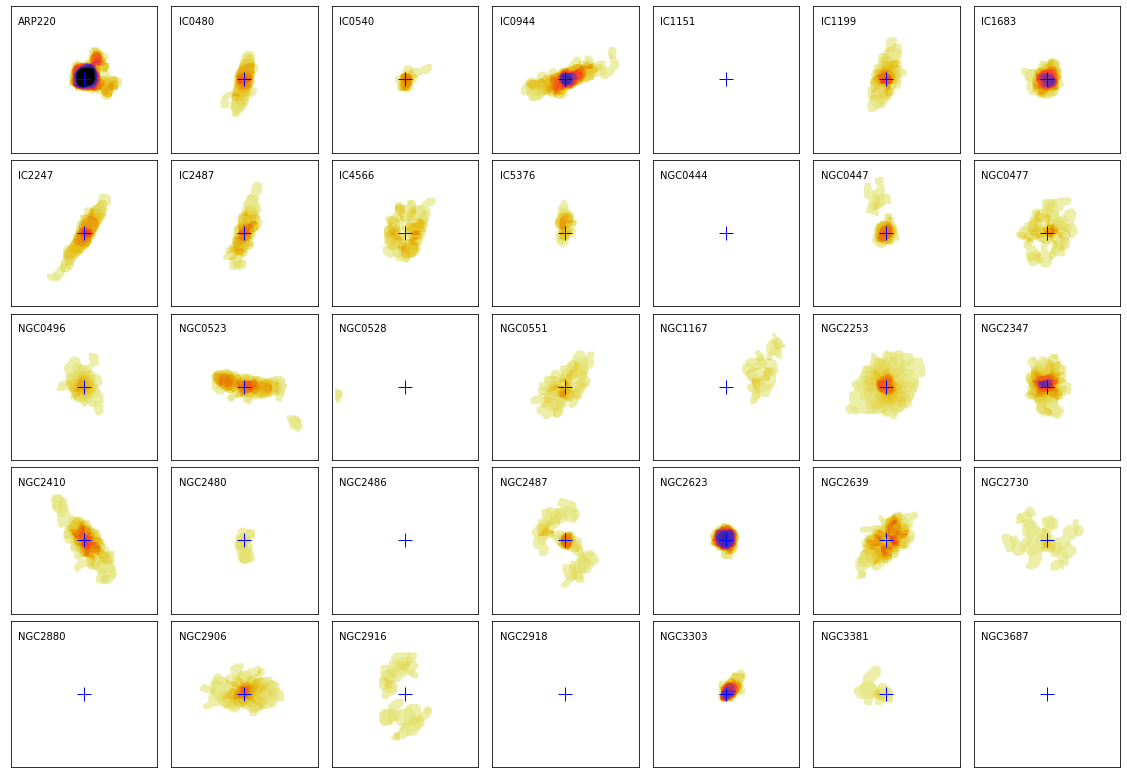

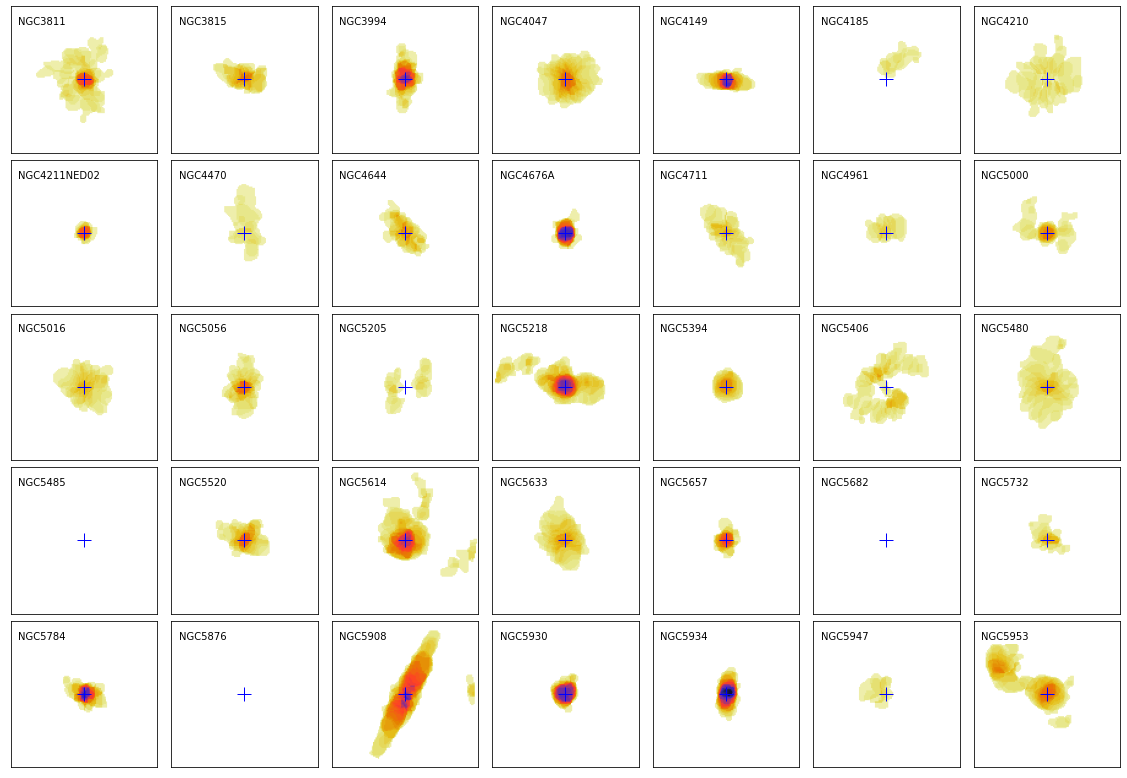

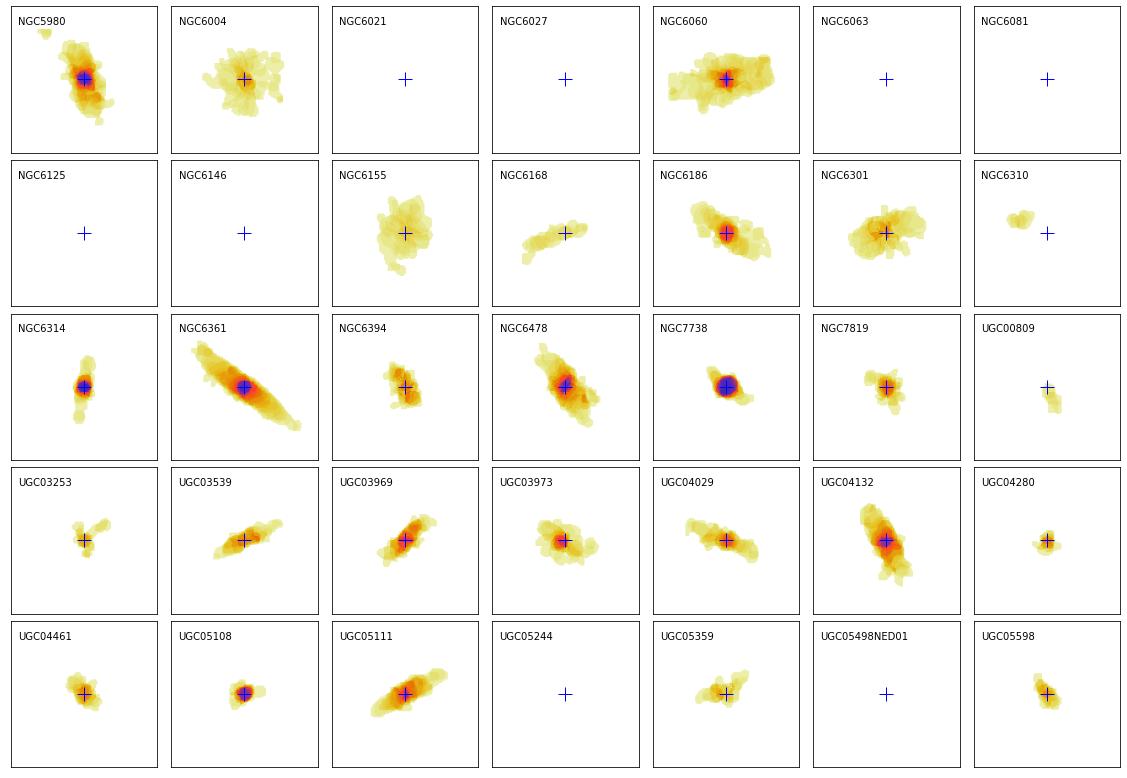

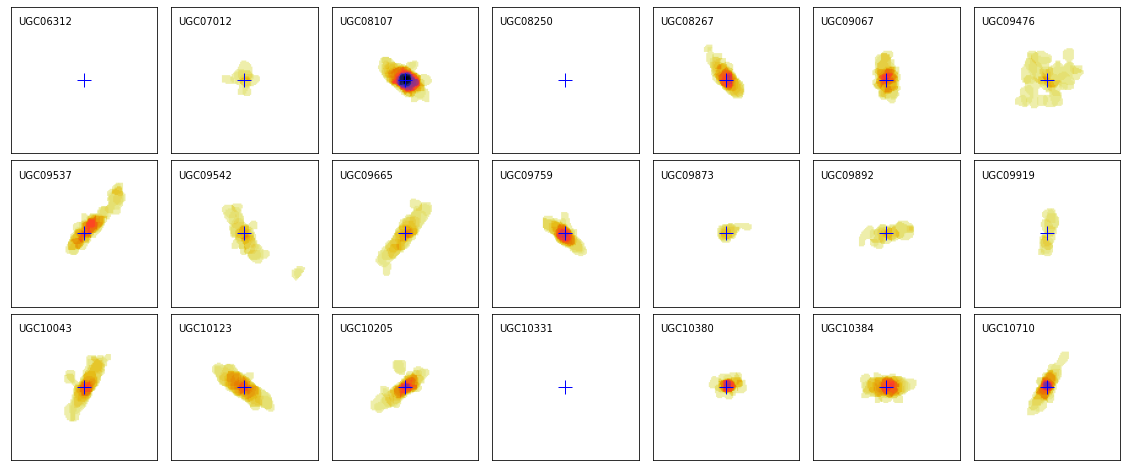

Python Results


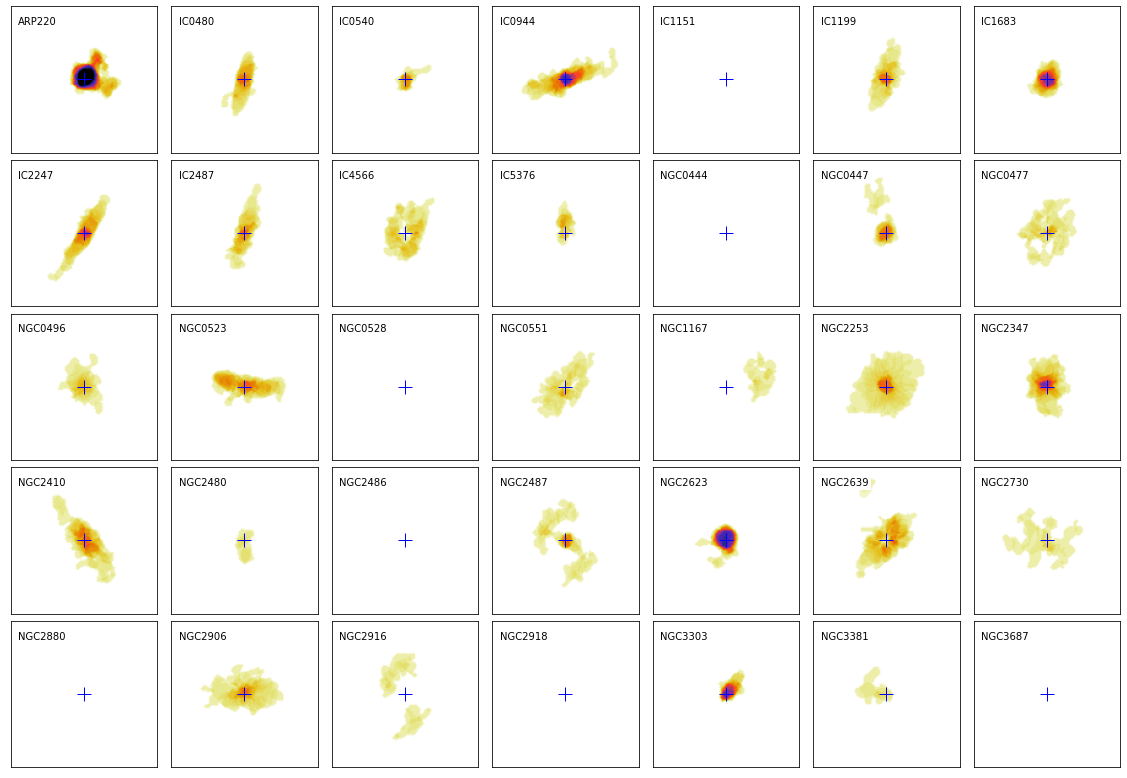

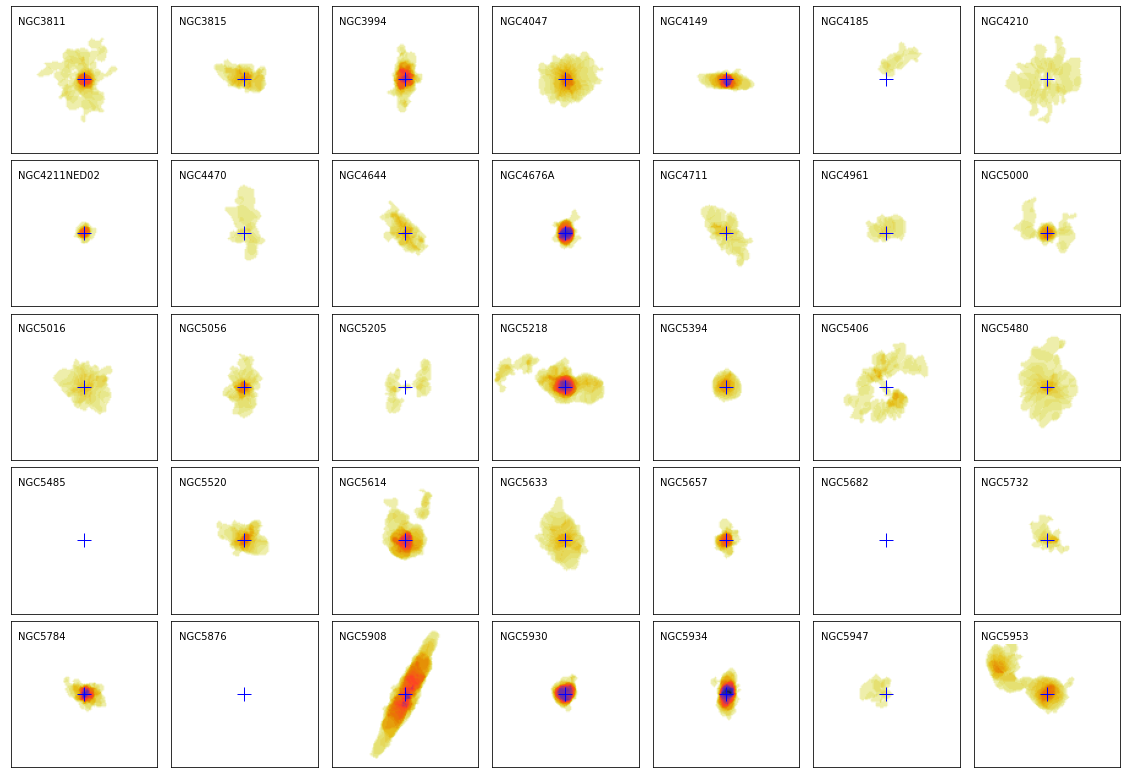

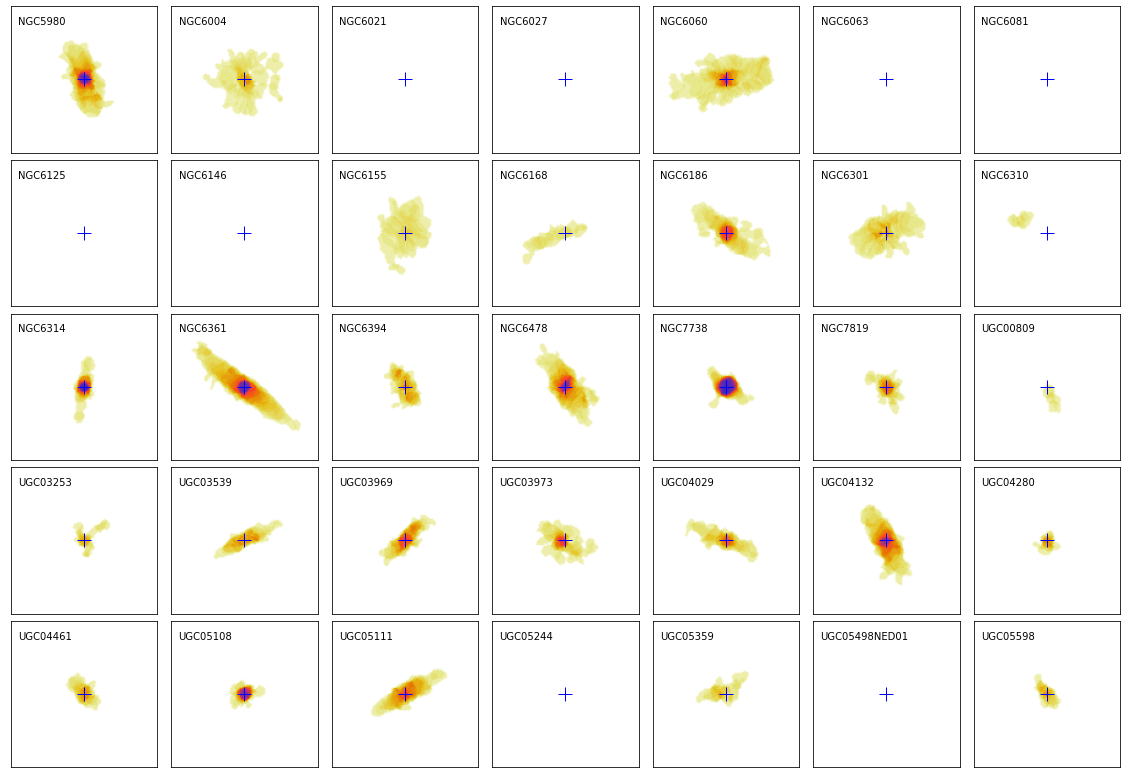

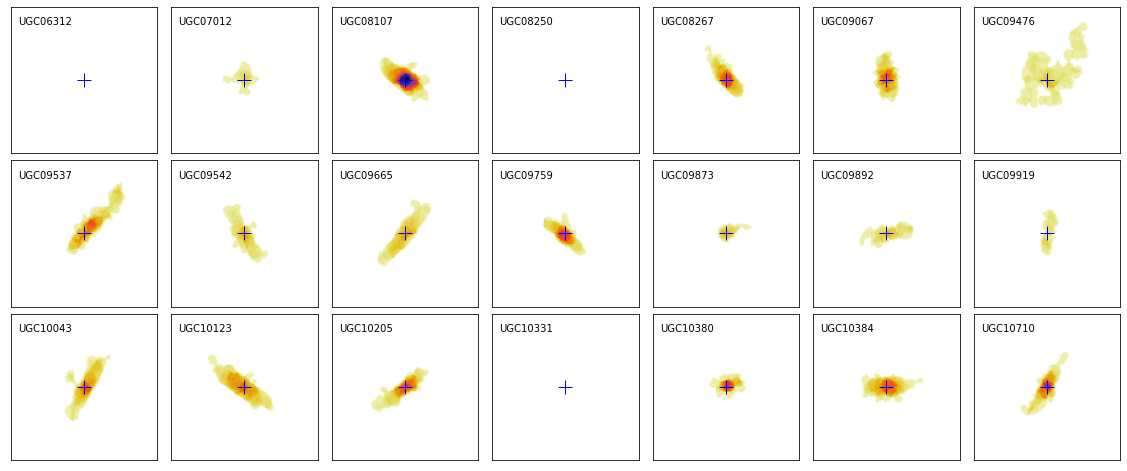

In [5]:
print('IDL Results')
implots(gallist, lbl='idl', imtype='smo7_dil.mask', imdir='../smo7_idlmom', ctr_tab=leda, pdfout=pdfout)
print('Python Results')
implots(gallist, lbl='py', imtype='smo7_dil.mask', imdir='../smo7_mom_vrad', ctr_tab=leda, pdfout=pdfout)

# Compare the dilated mom-1

IDL Results


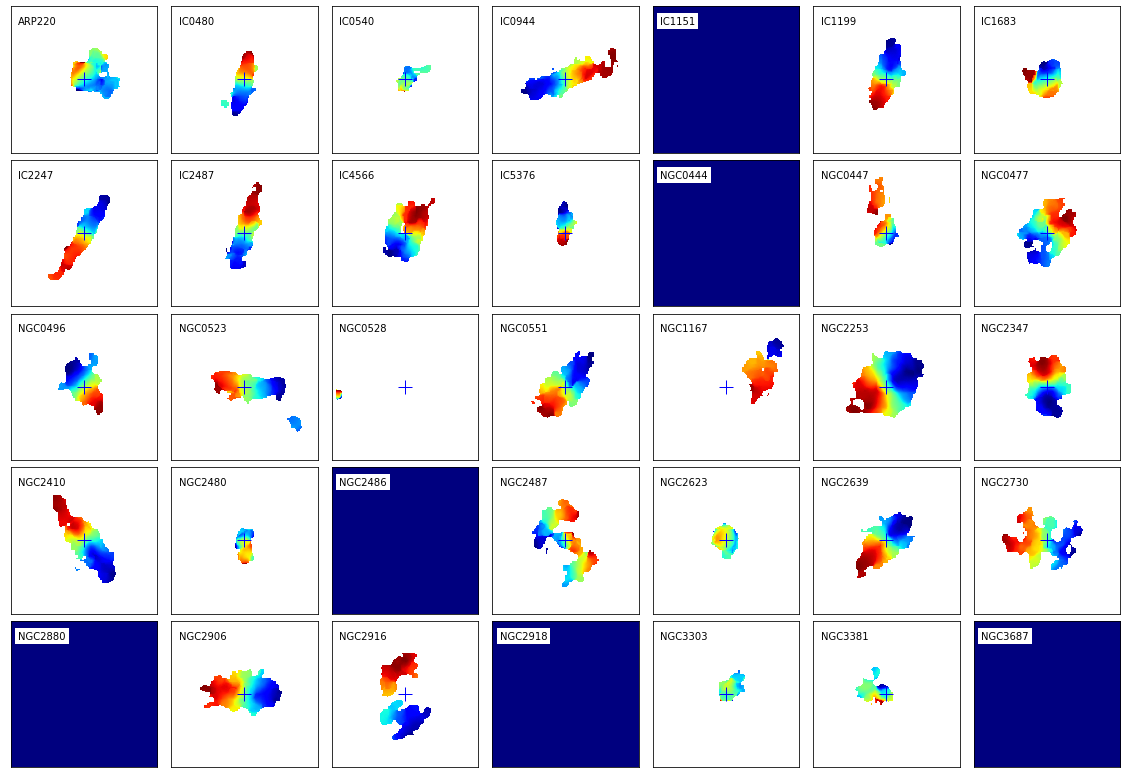

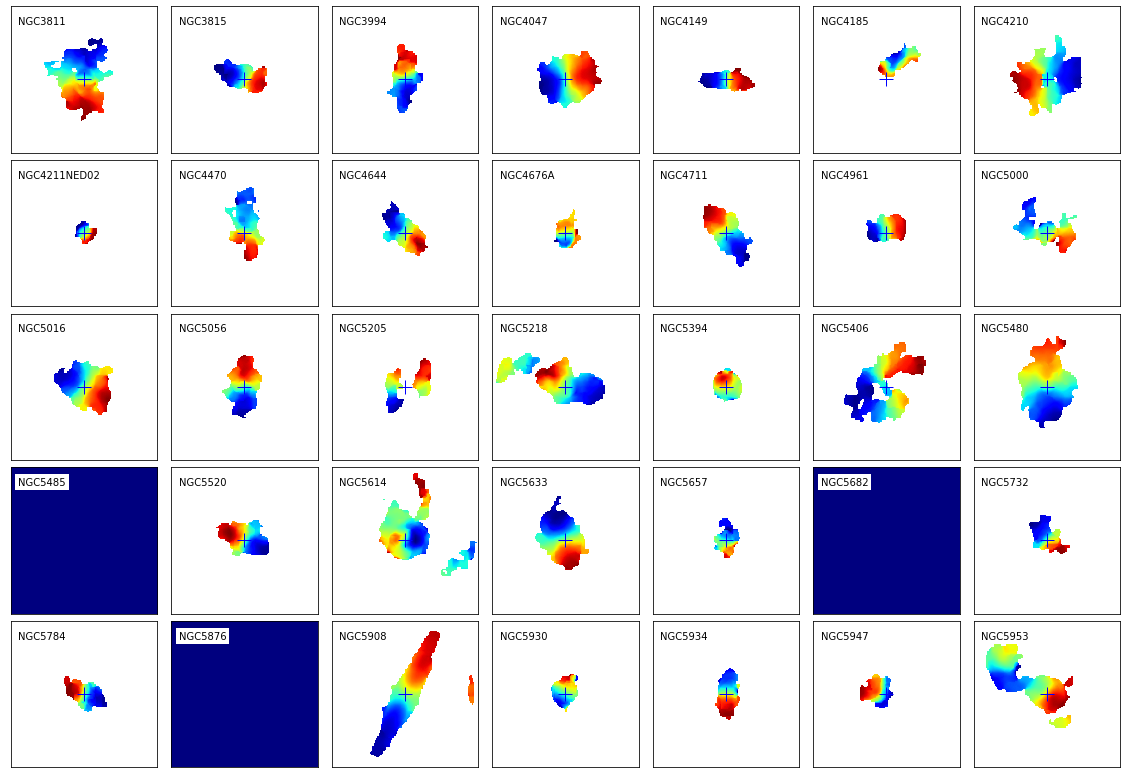

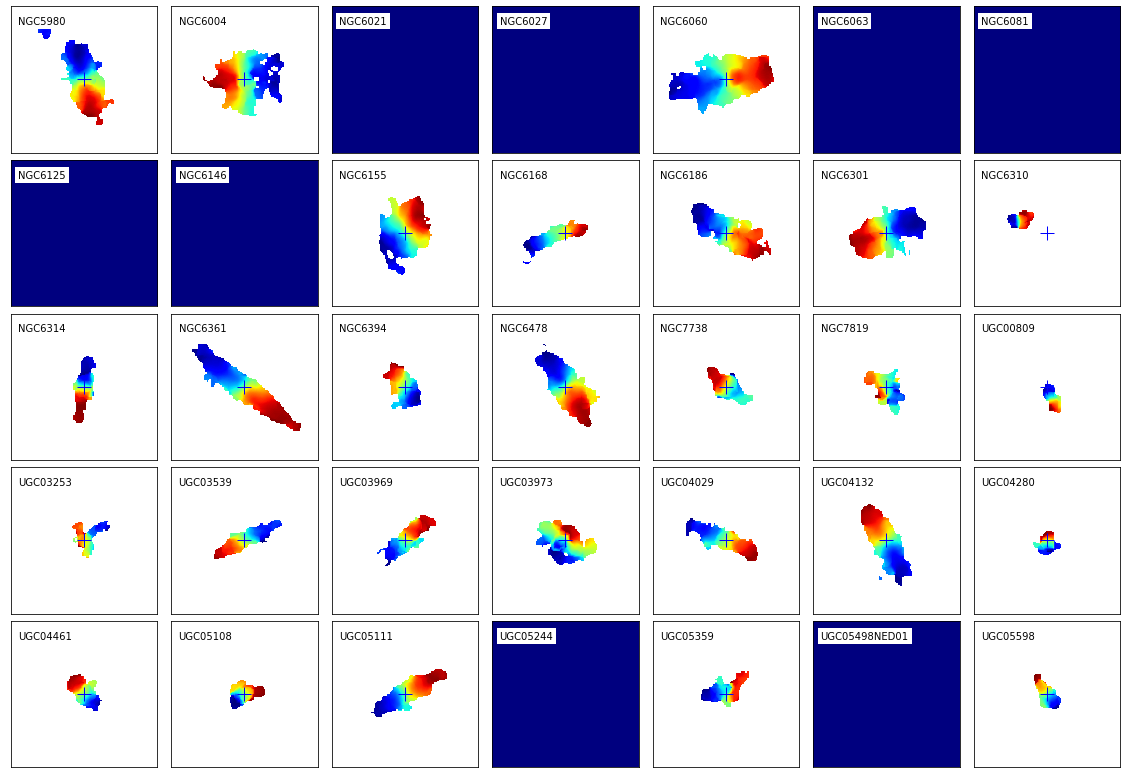

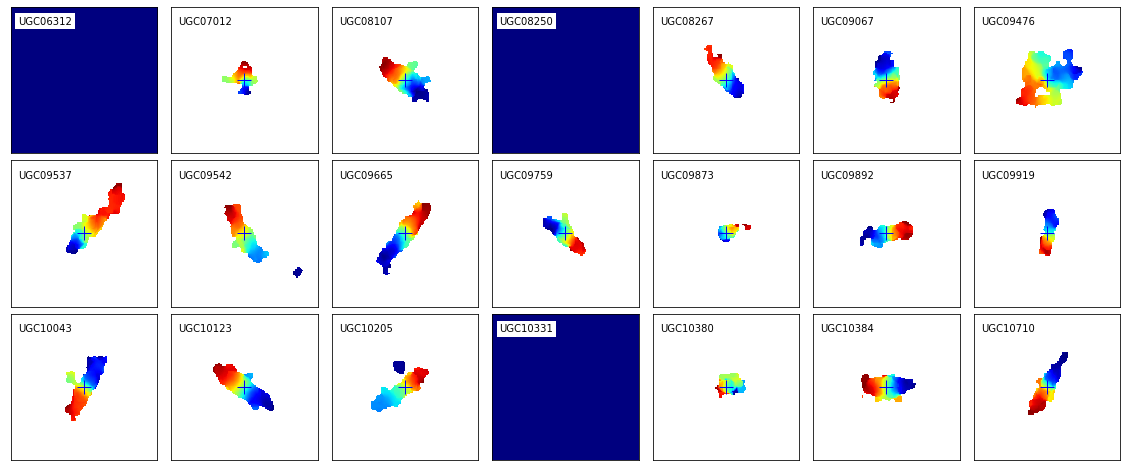

Python Results


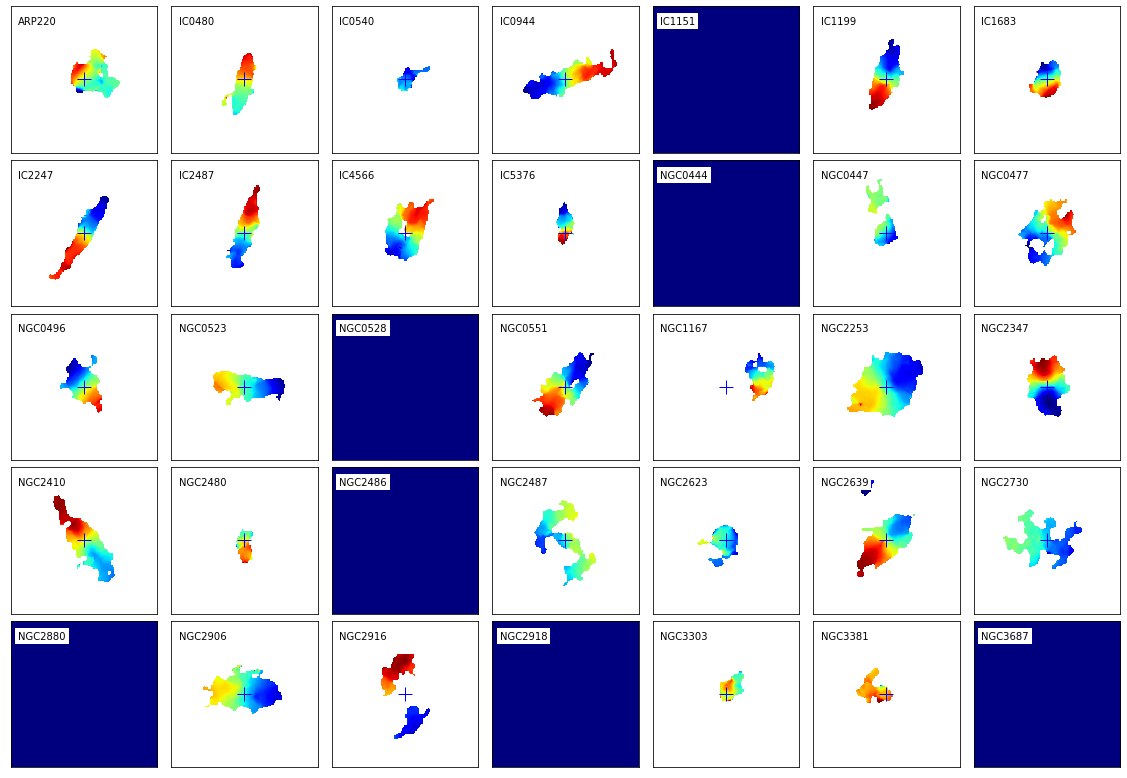

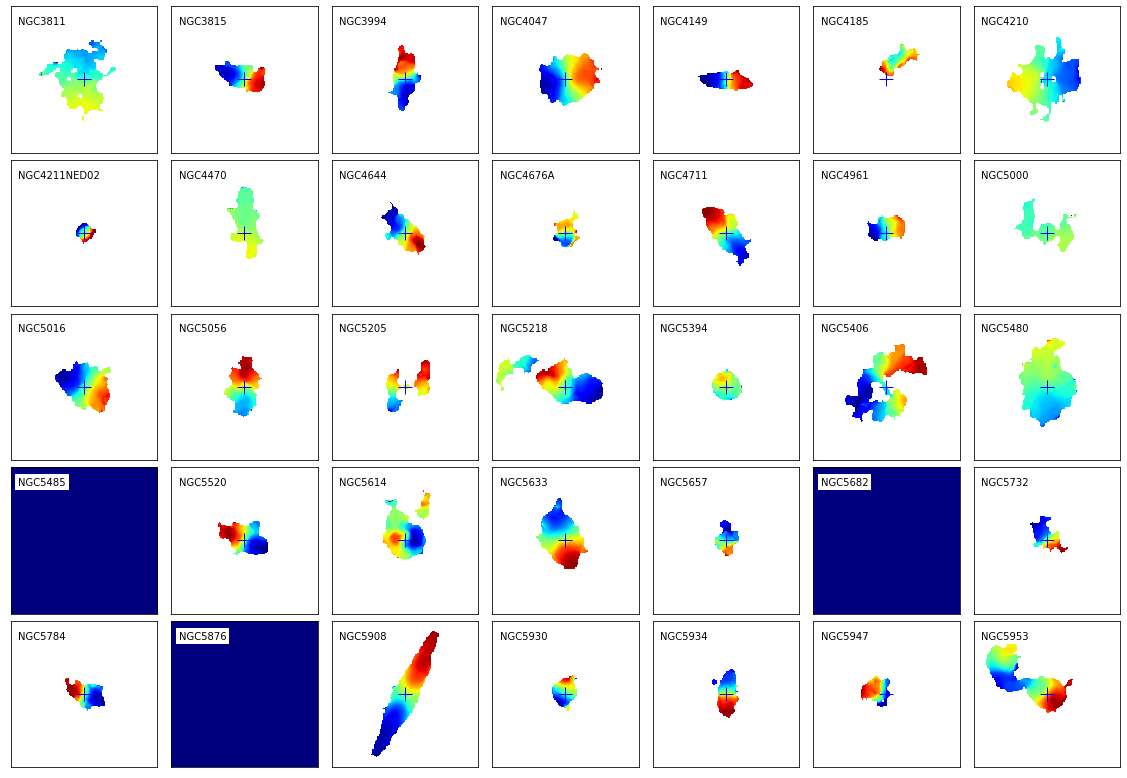

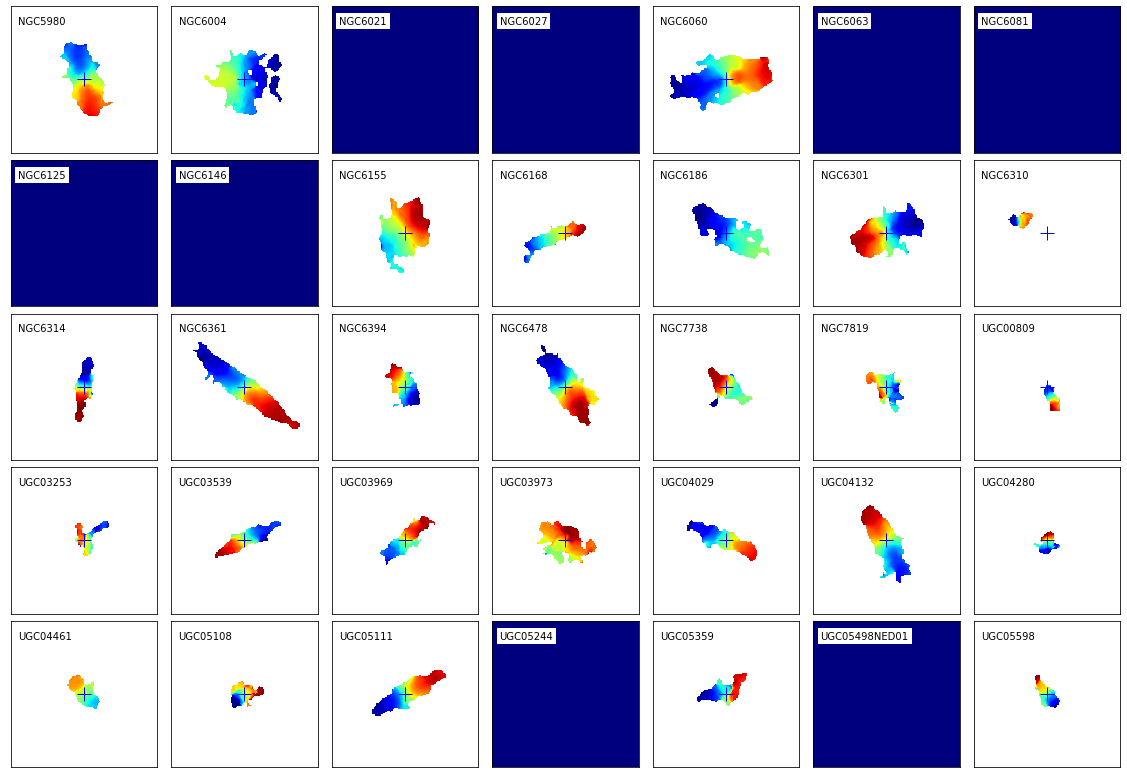

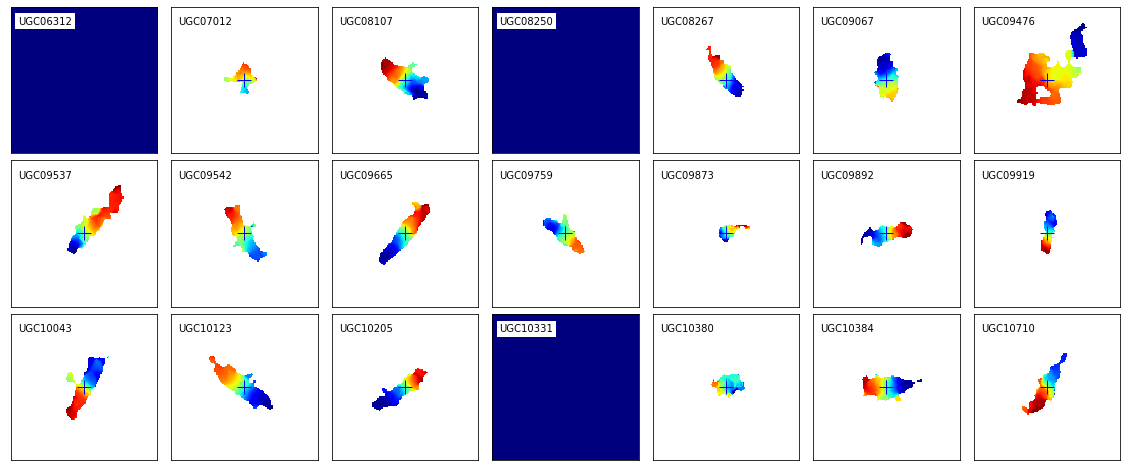

Python Results with error masking


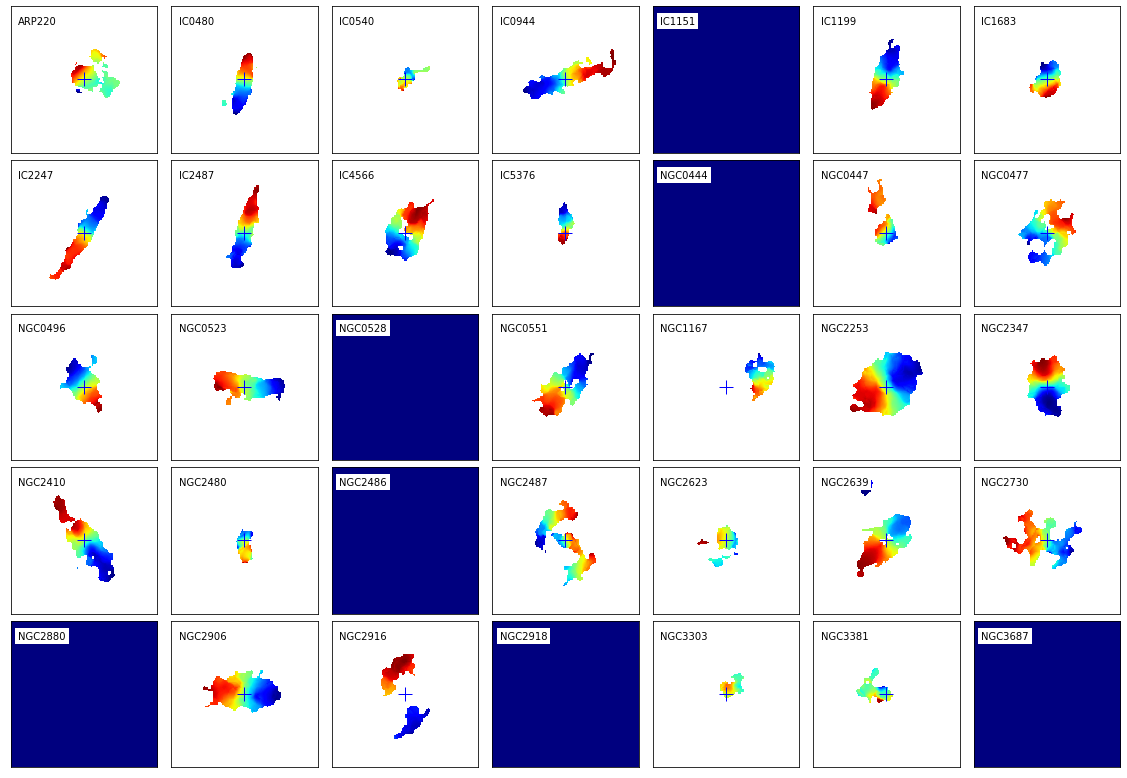

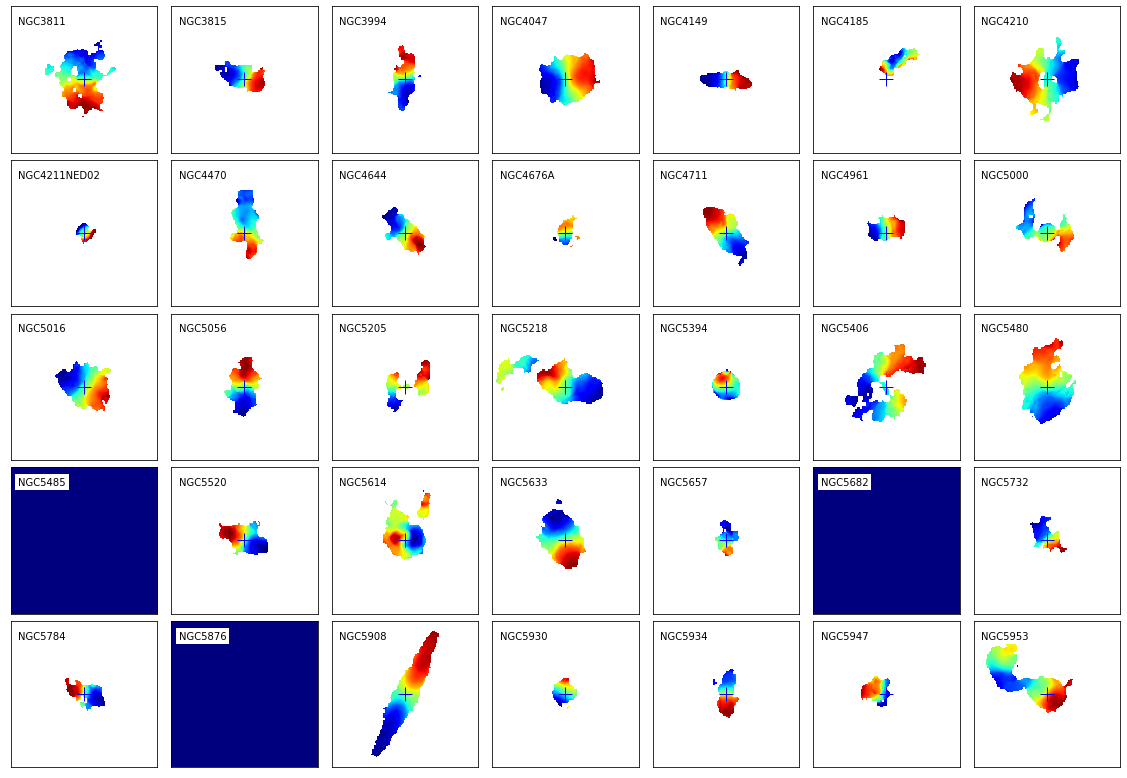

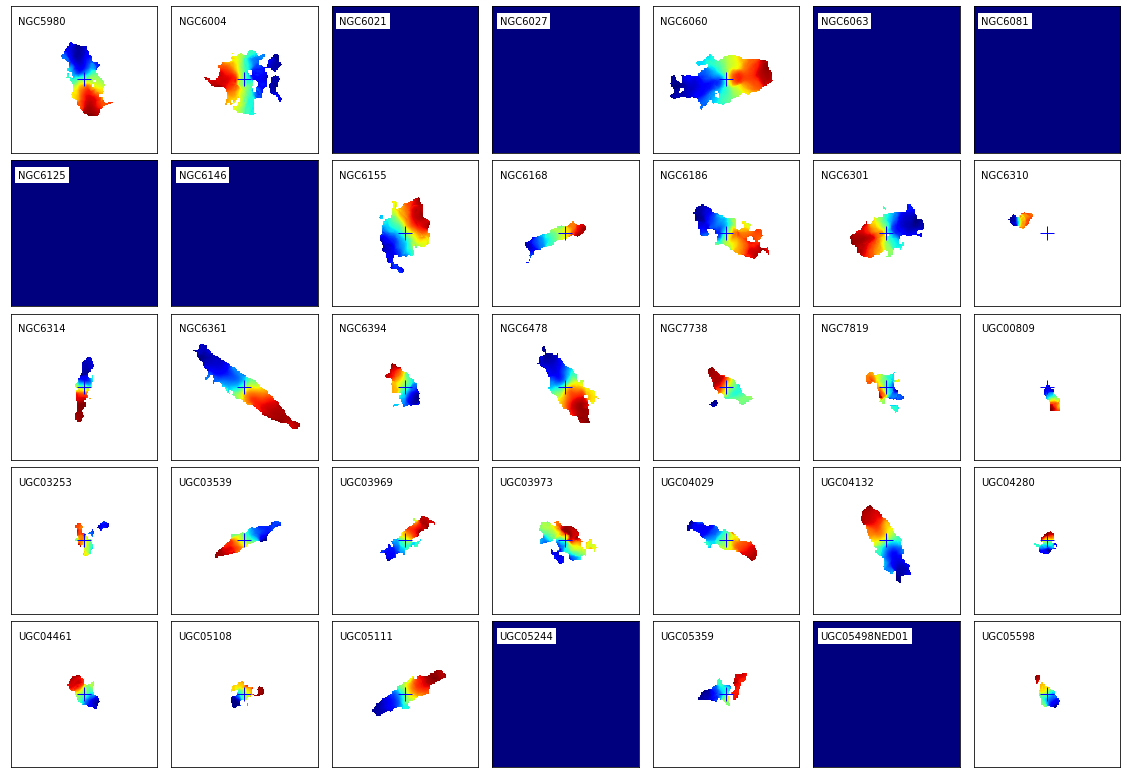

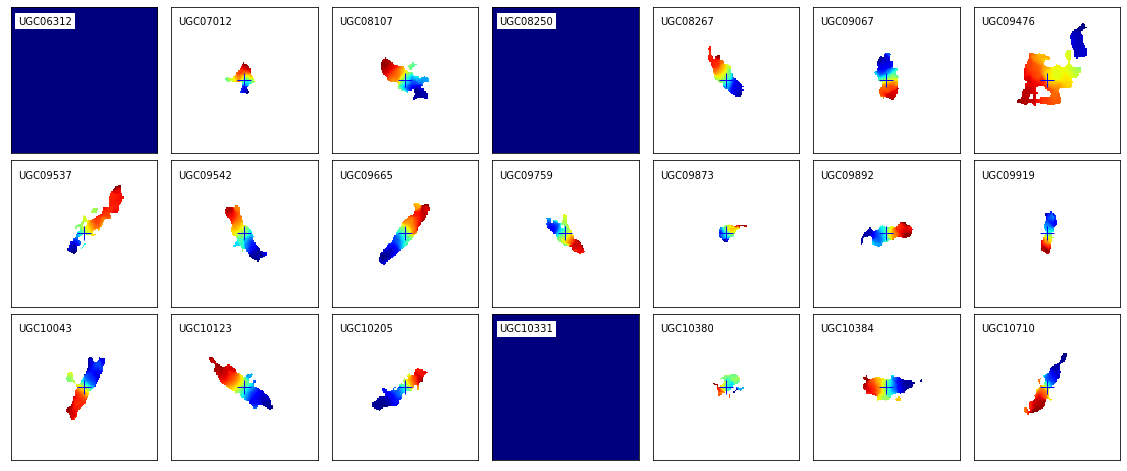

In [6]:
print('IDL Results')
implots(gallist, lbl='idl', imtype='smo7_dil.mom1', imdir='../smo7_idlmom', ctr_tab=leda, pdfout=pdfout)
print('Python Results')
implots(gallist, lbl='py', imtype='smo7_dil.mom1', imdir='../smo7_mom_vrad', ctr_tab=leda, pdfout=pdfout)
print('Python Results with error masking')
implots(gallist, lbl='py', imtype='smo7_dil.mom1', imdir='../smo7_mom_vrad', ctr_tab=leda, 
        errtype='smo7_dil.emom1', pdfout=pdfout)

# Compare the smoothed masks

IDL Results


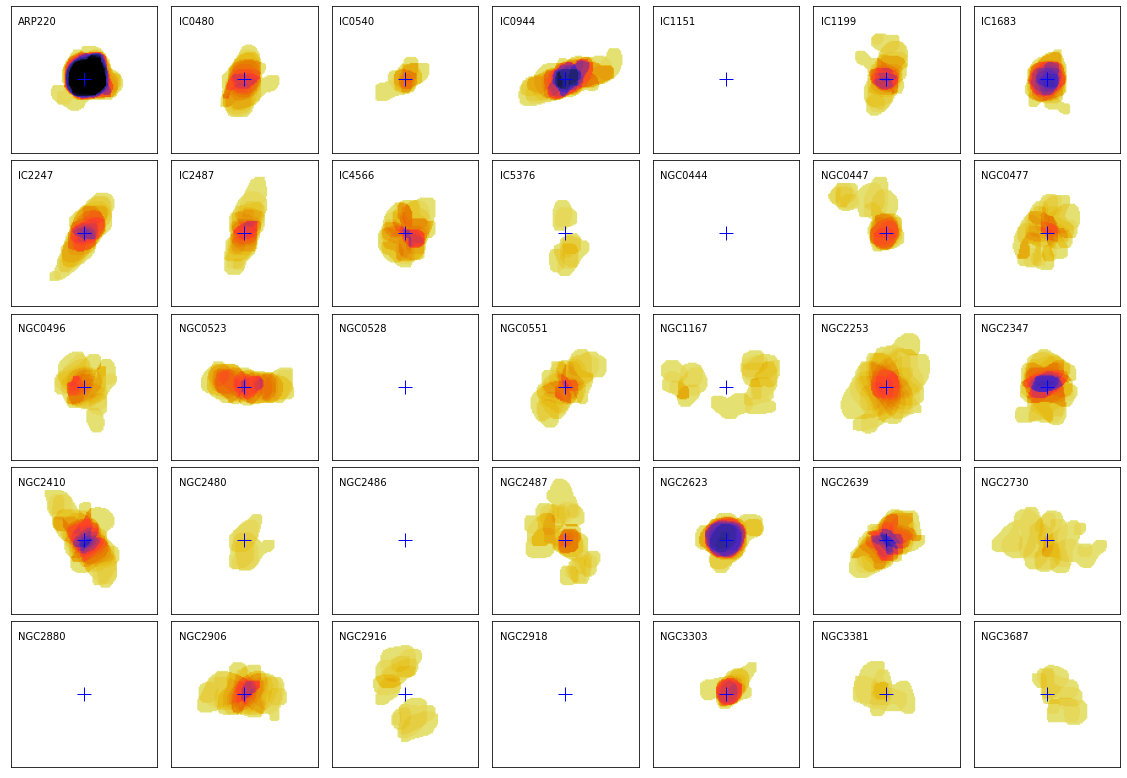

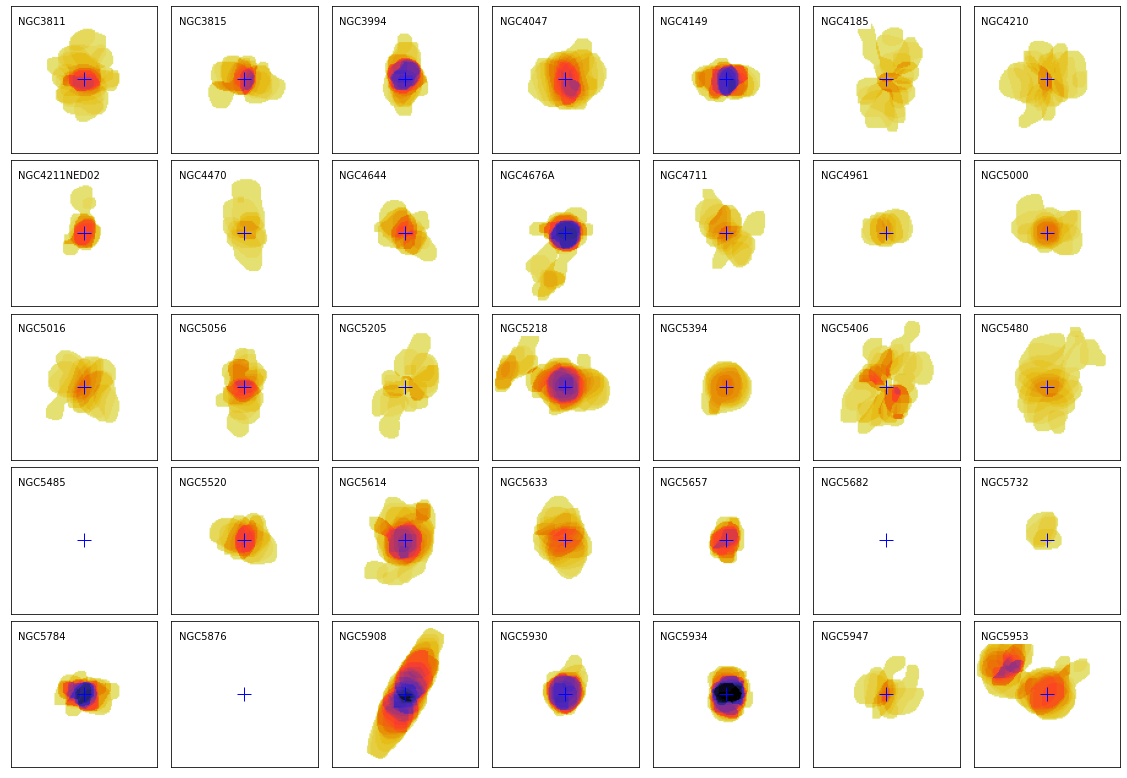

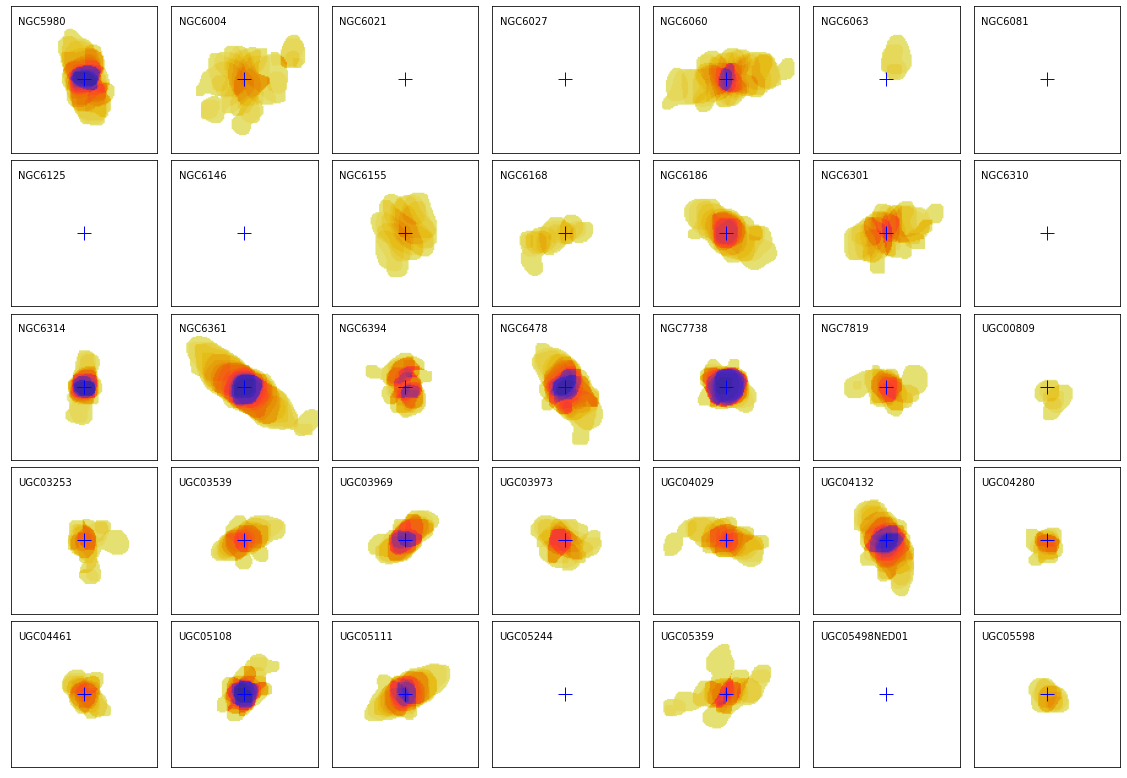

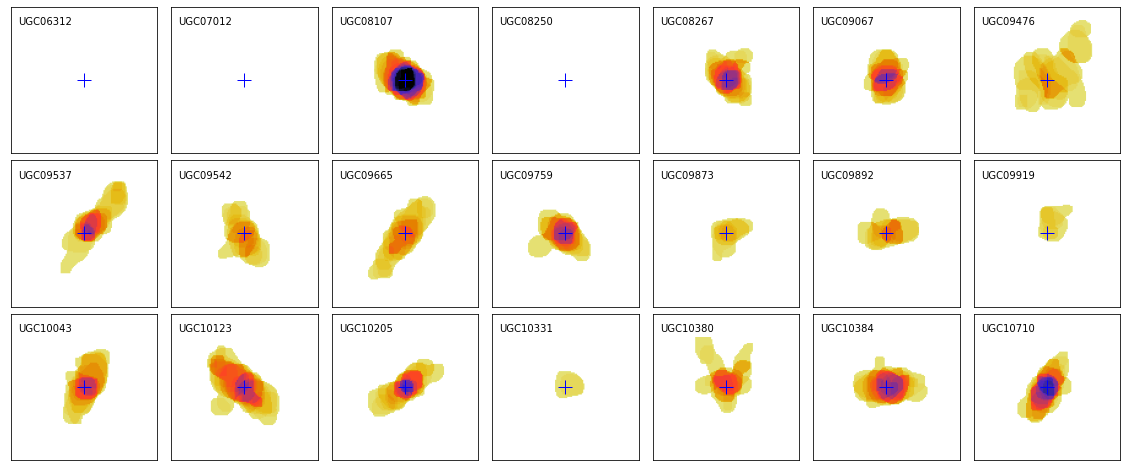

Python Results


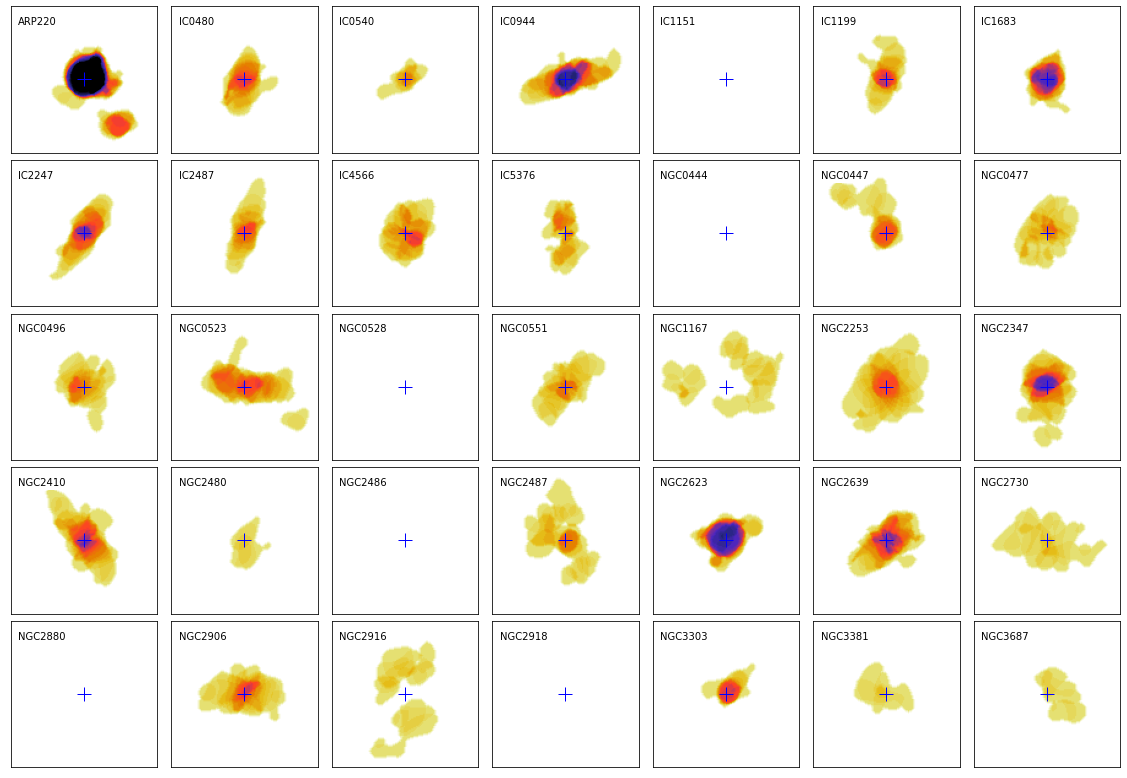

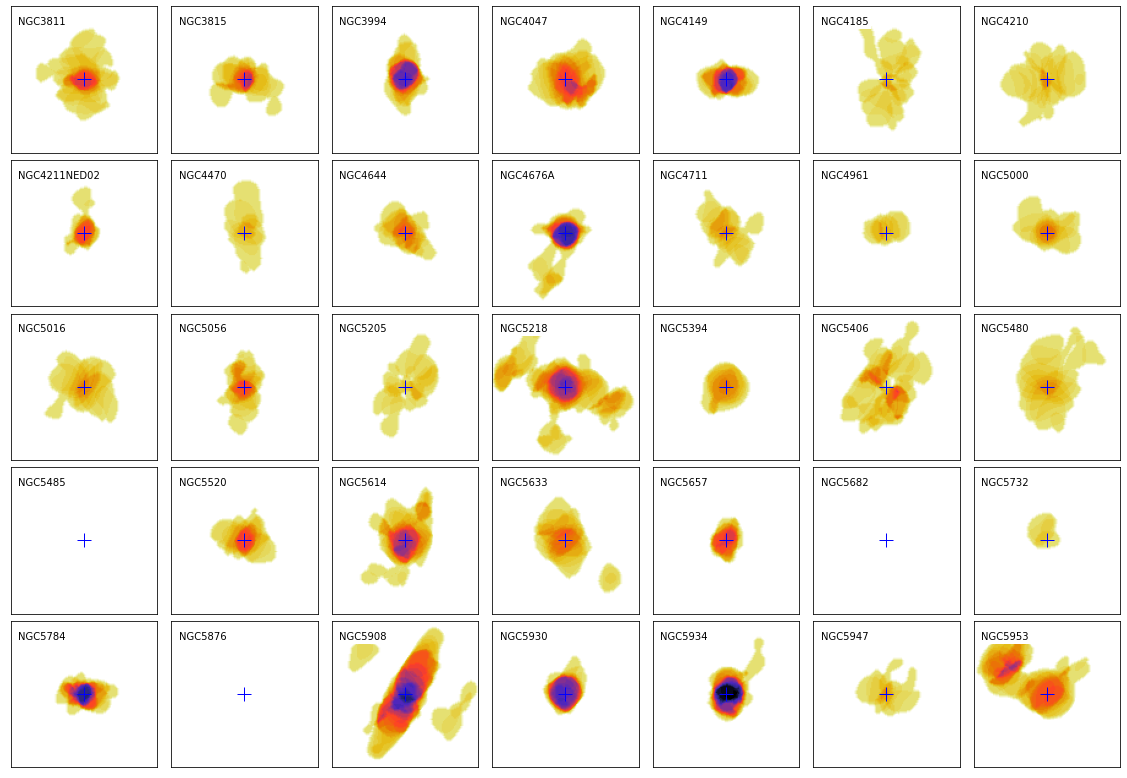

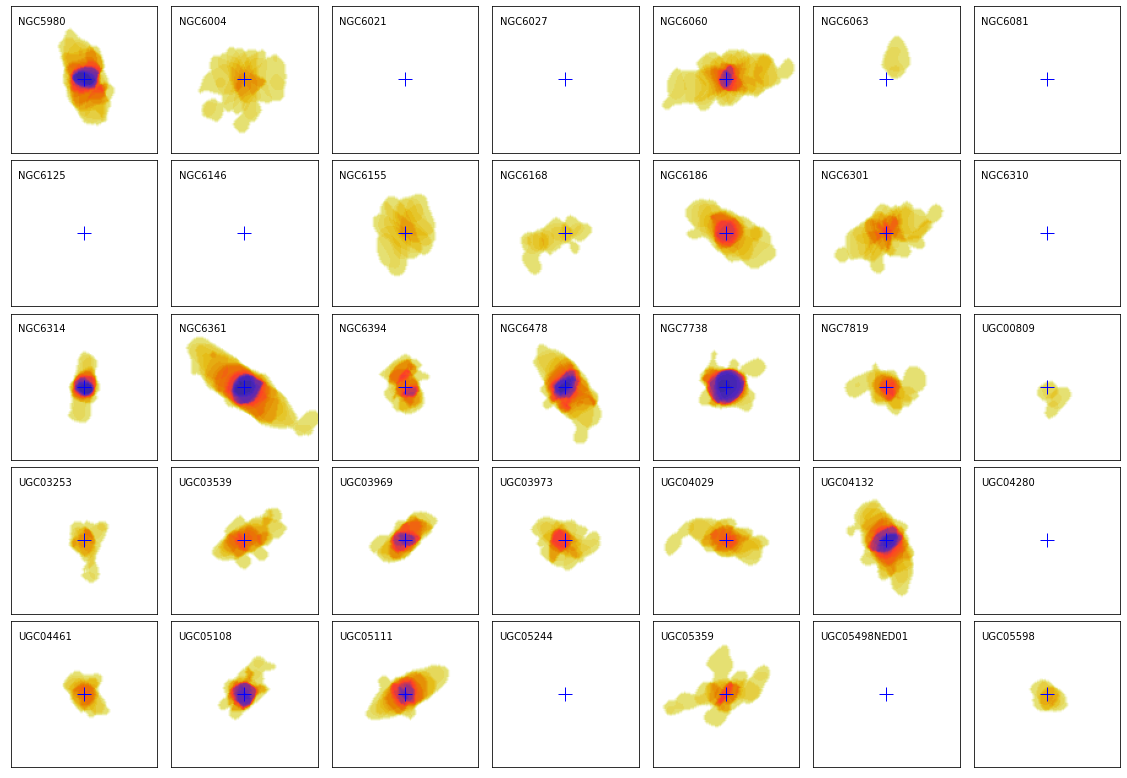

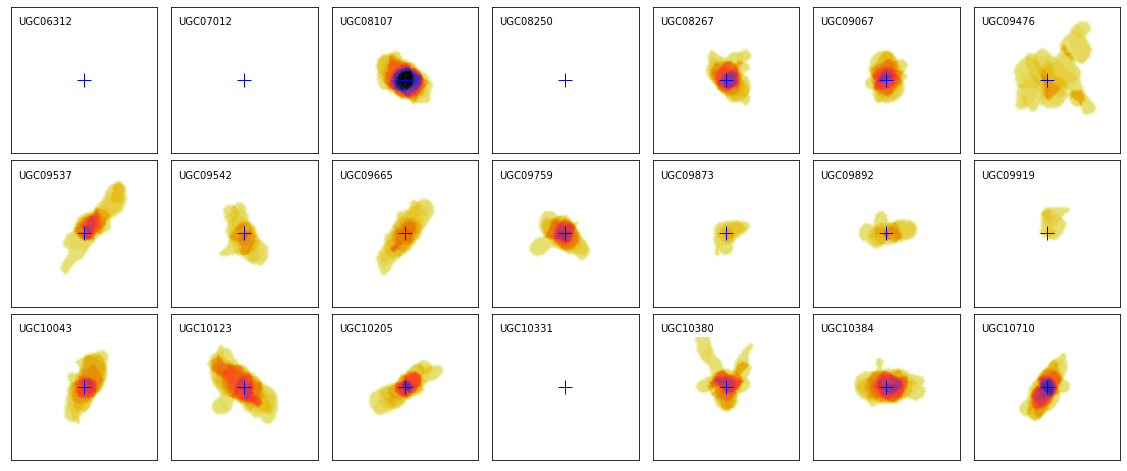

In [7]:
print('IDL Results')
implots(gallist, lbl='idl', imtype='smo7_smo.mask', imdir='../smo7_idlmom', ctr_tab=leda, pdfout=pdfout)
print('Python Results')
implots(gallist, lbl='py', imtype='smo7_smo.mask', imdir='../smo7_mom_vrad', ctr_tab=leda, pdfout=pdfout)

# Compare the smoothed mom-0

IDL Results


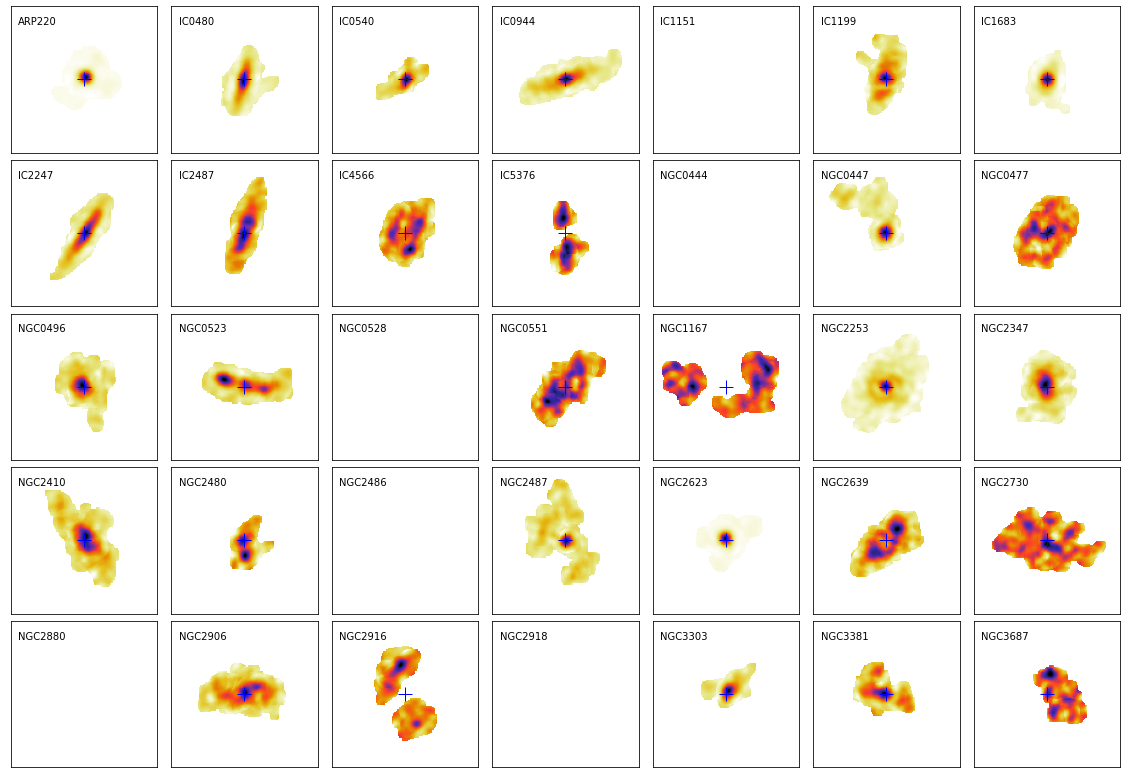

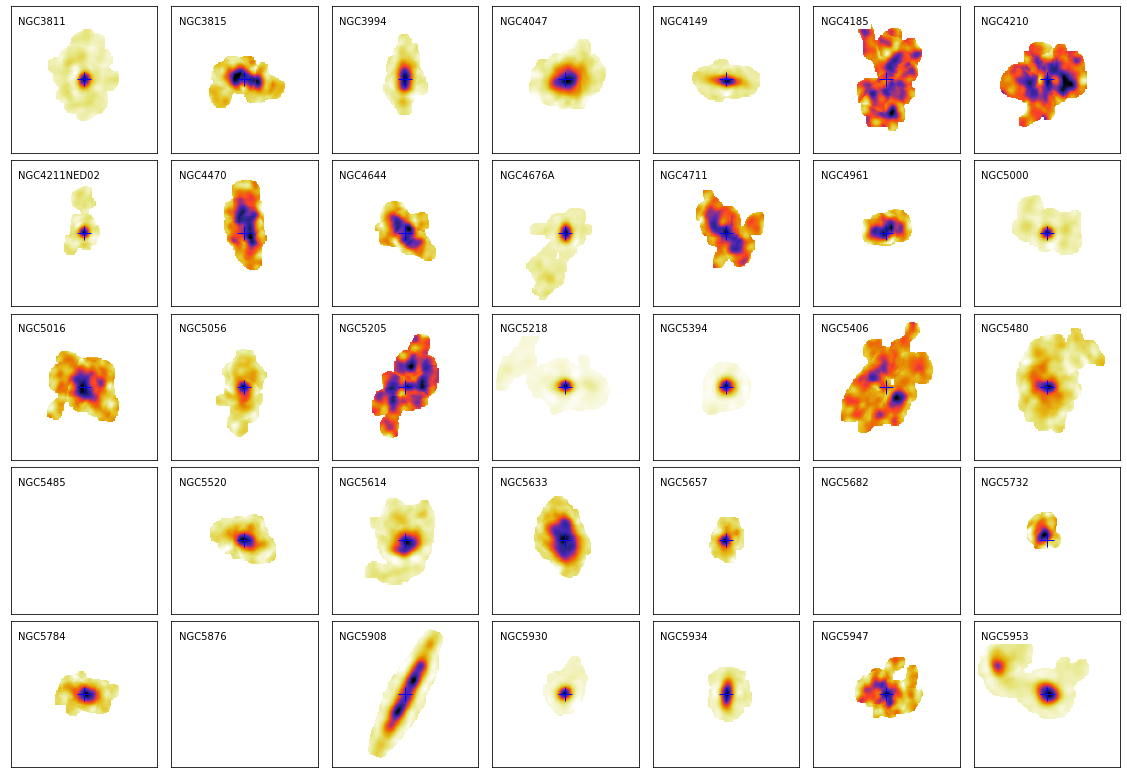

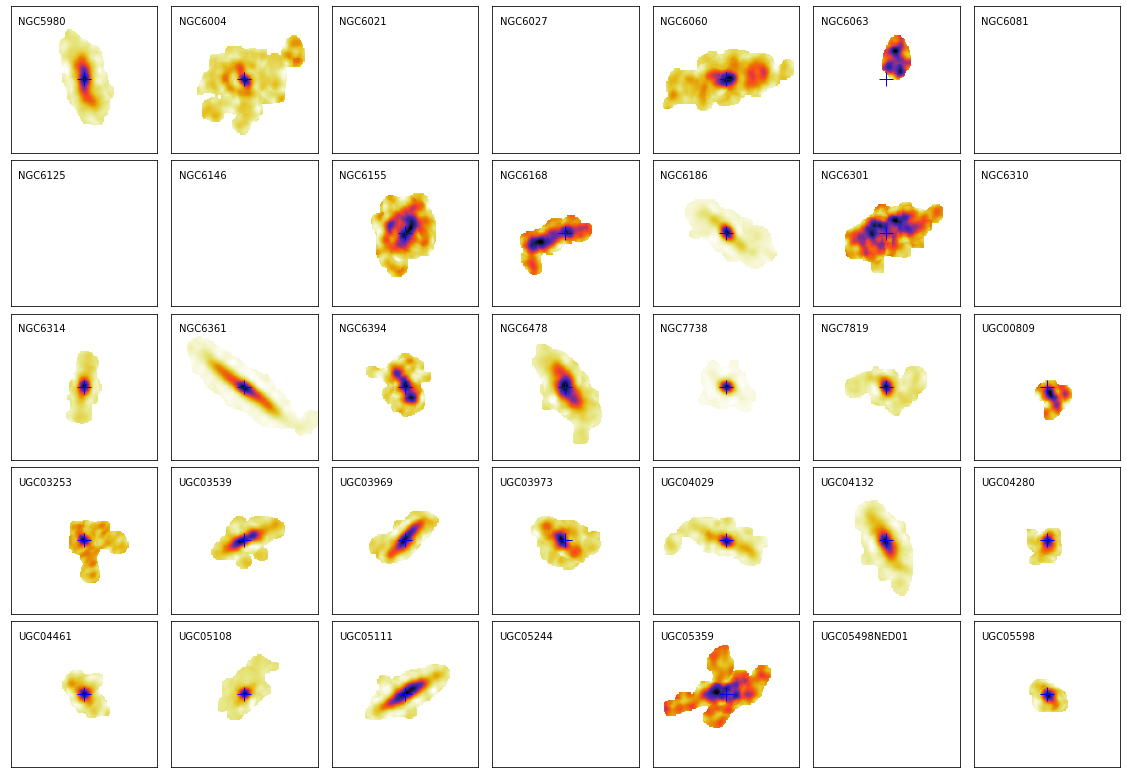

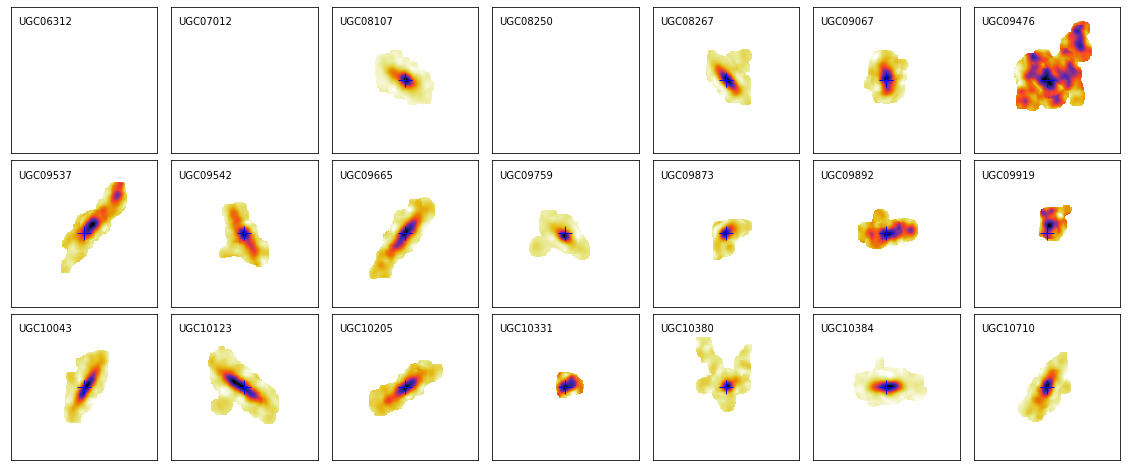

Python Results


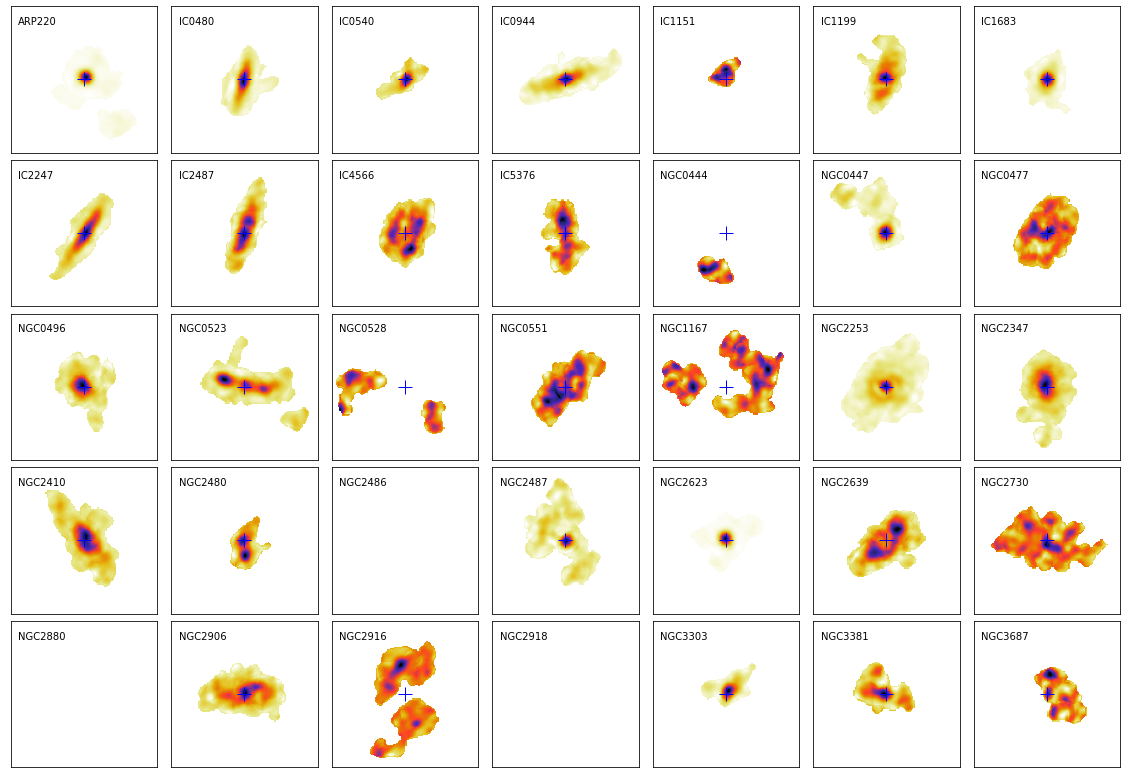

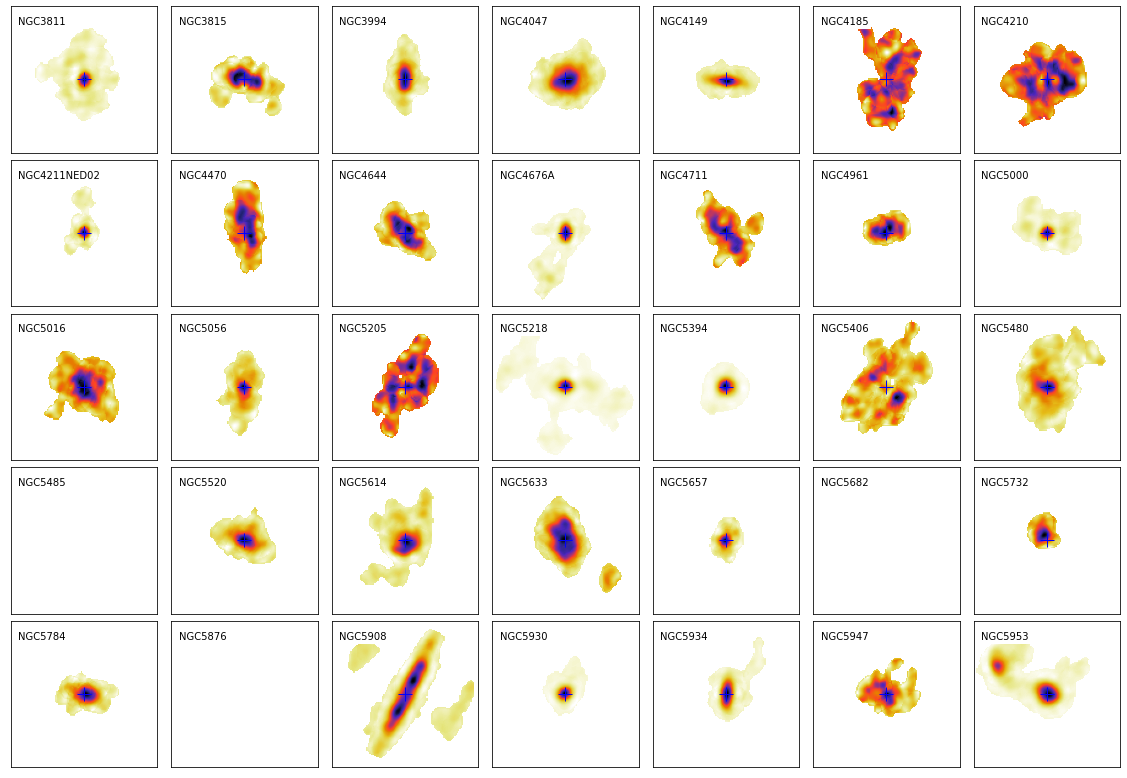

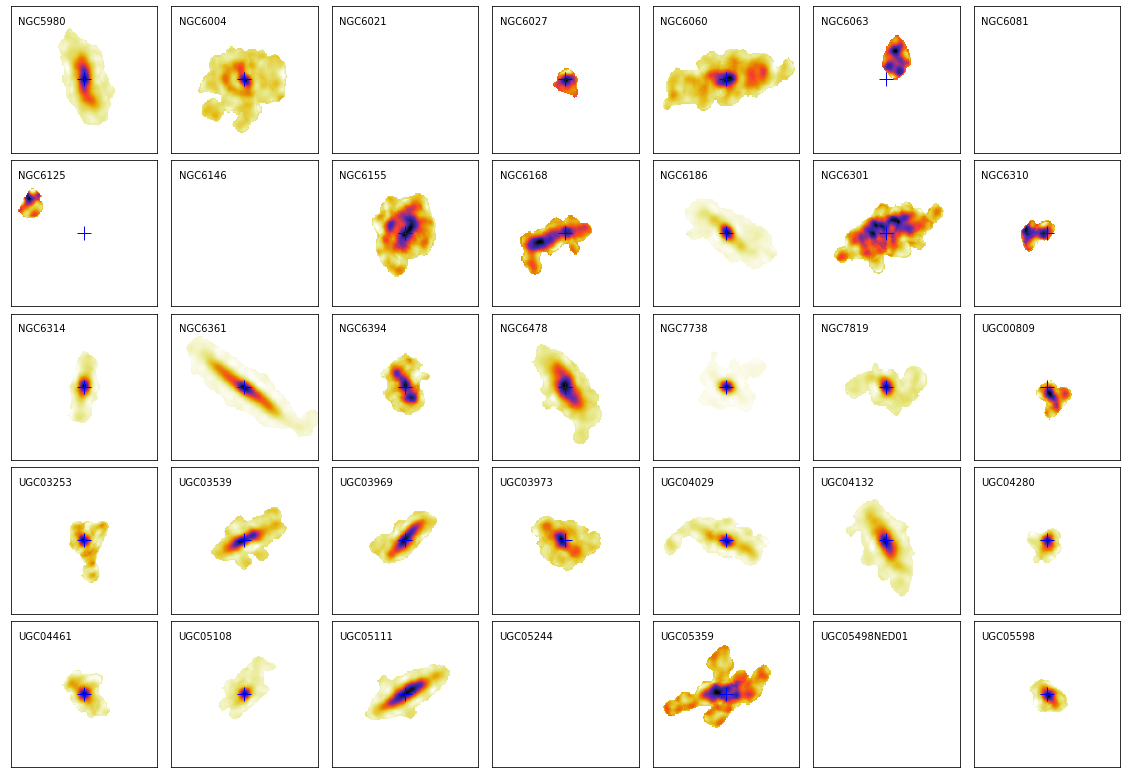

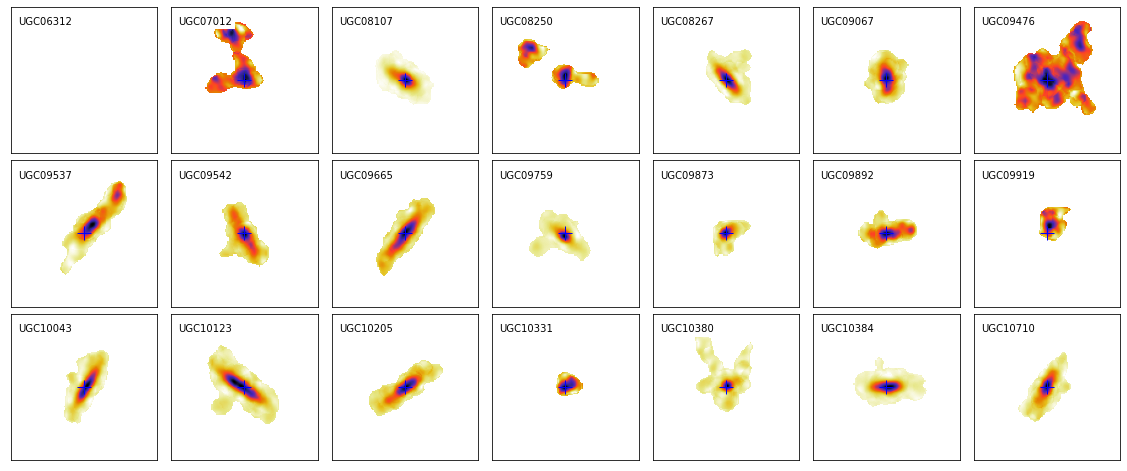

In [8]:
print('IDL Results')
implots(gallist, lbl='idl', imtype='smo7_smo.mom0', imdir='../smo7_idlmom', ctr_tab=leda, pdfout=pdfout)
print('Python Results')
implots(gallist, lbl='py', imtype='smo7_smo.mom0', imdir='../smo7_mom_vrad', ctr_tab=leda, pdfout=pdfout)

# Compare the smoothed mom-1

IDL Results


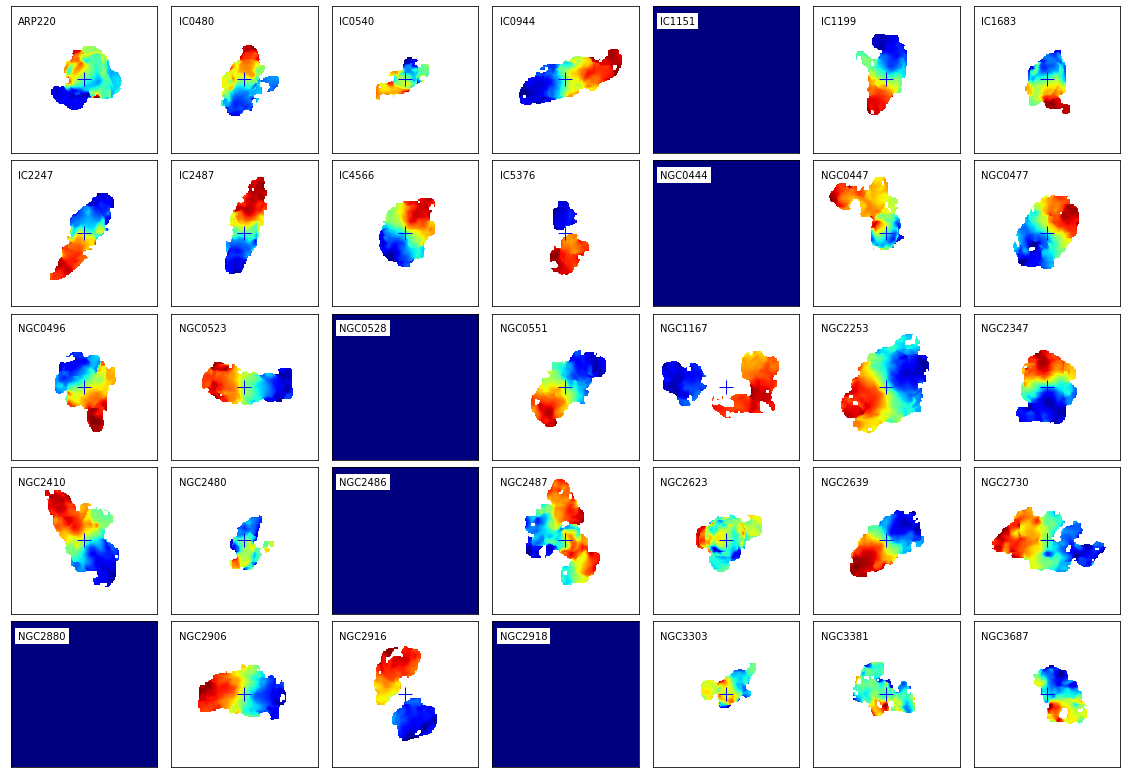

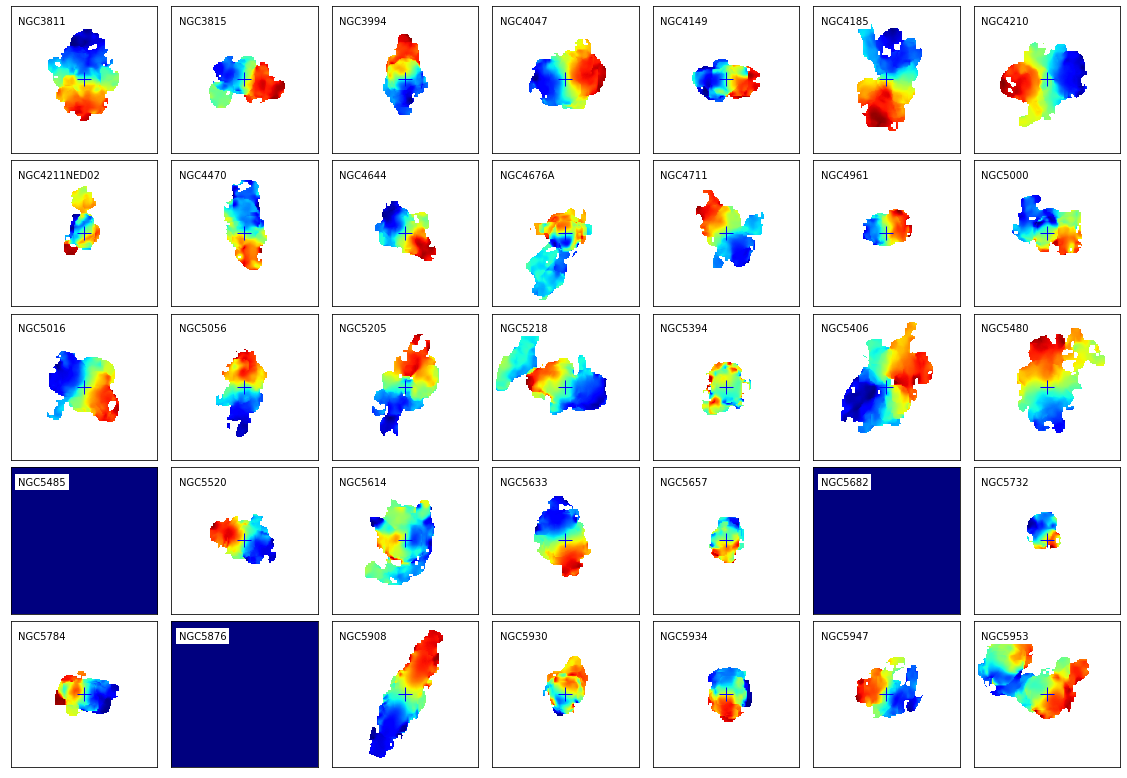

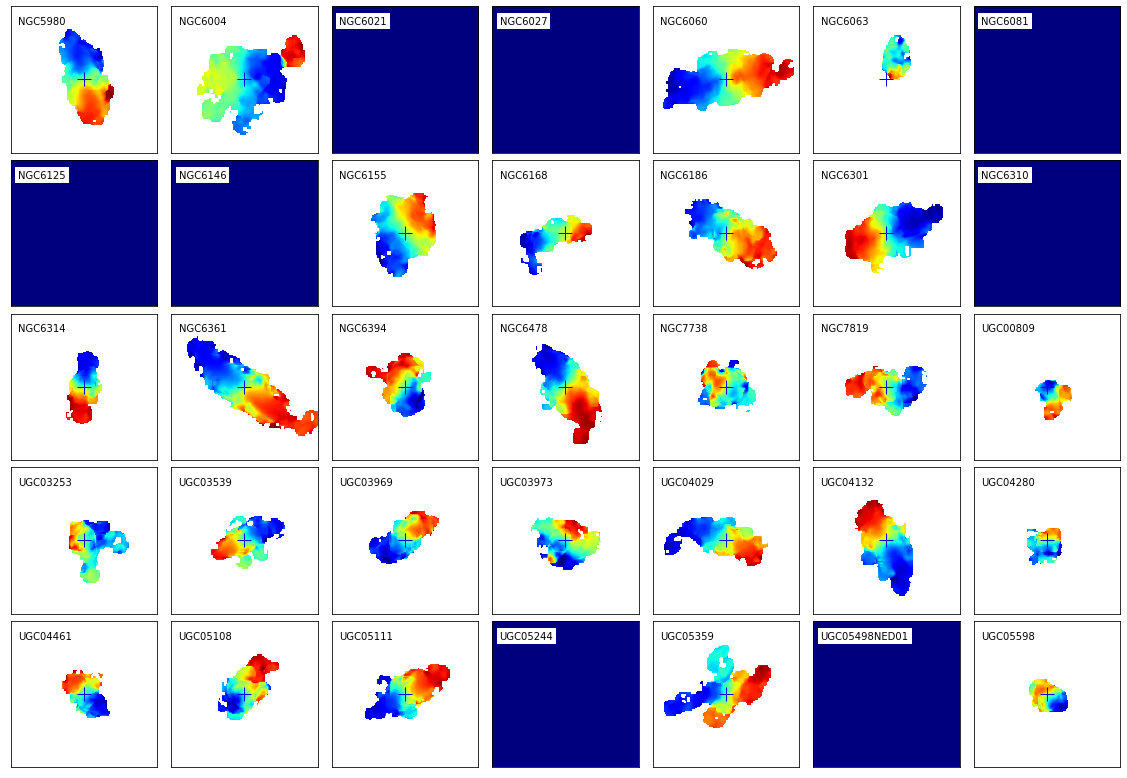

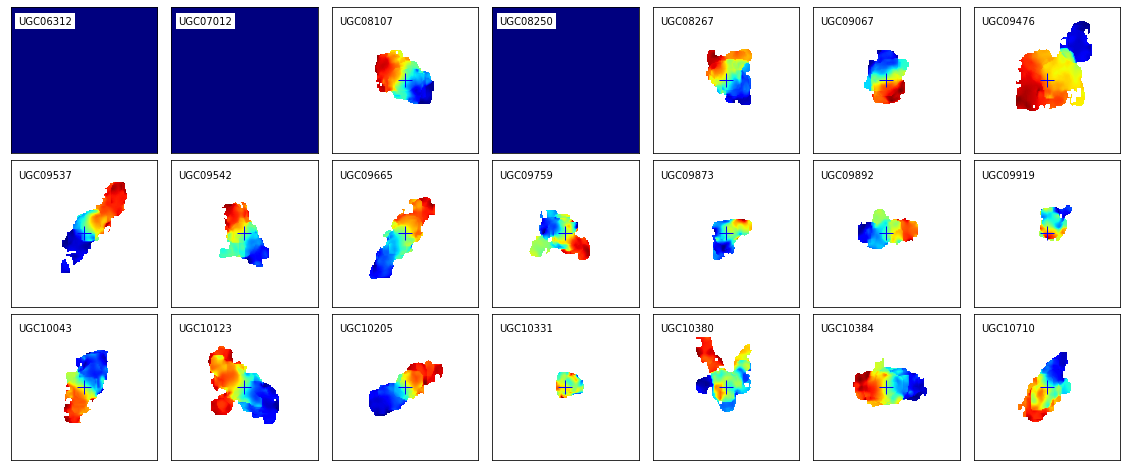

Python Results


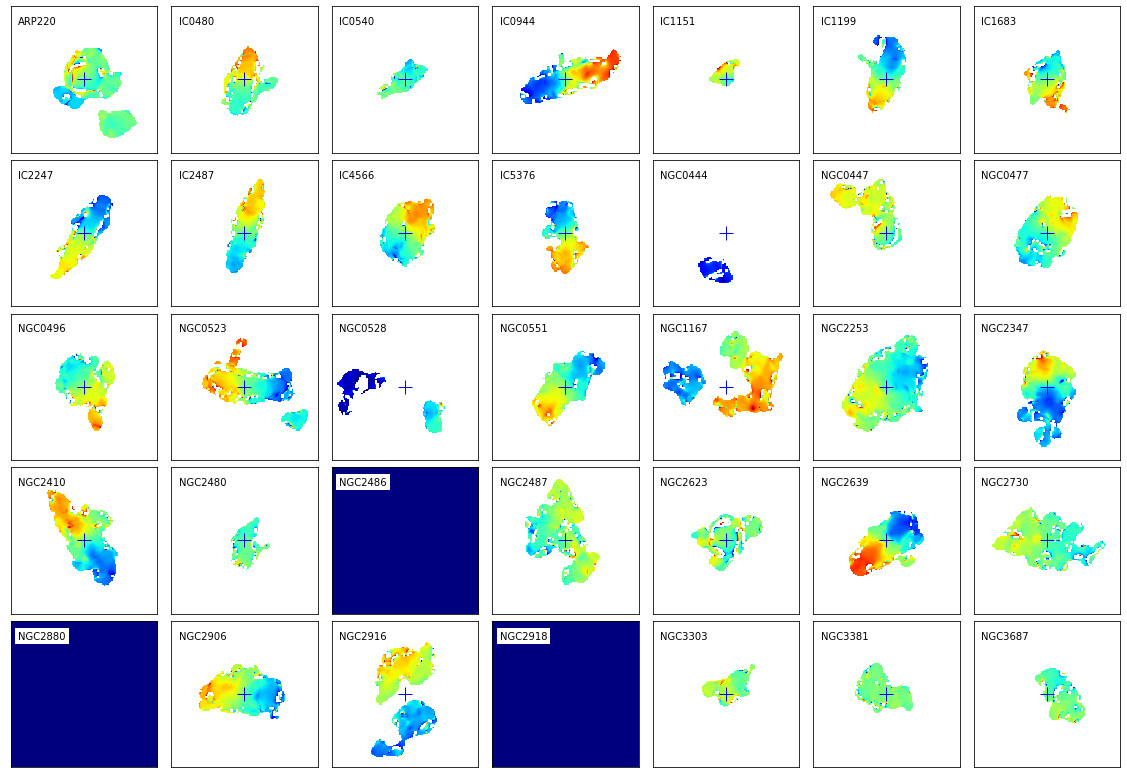

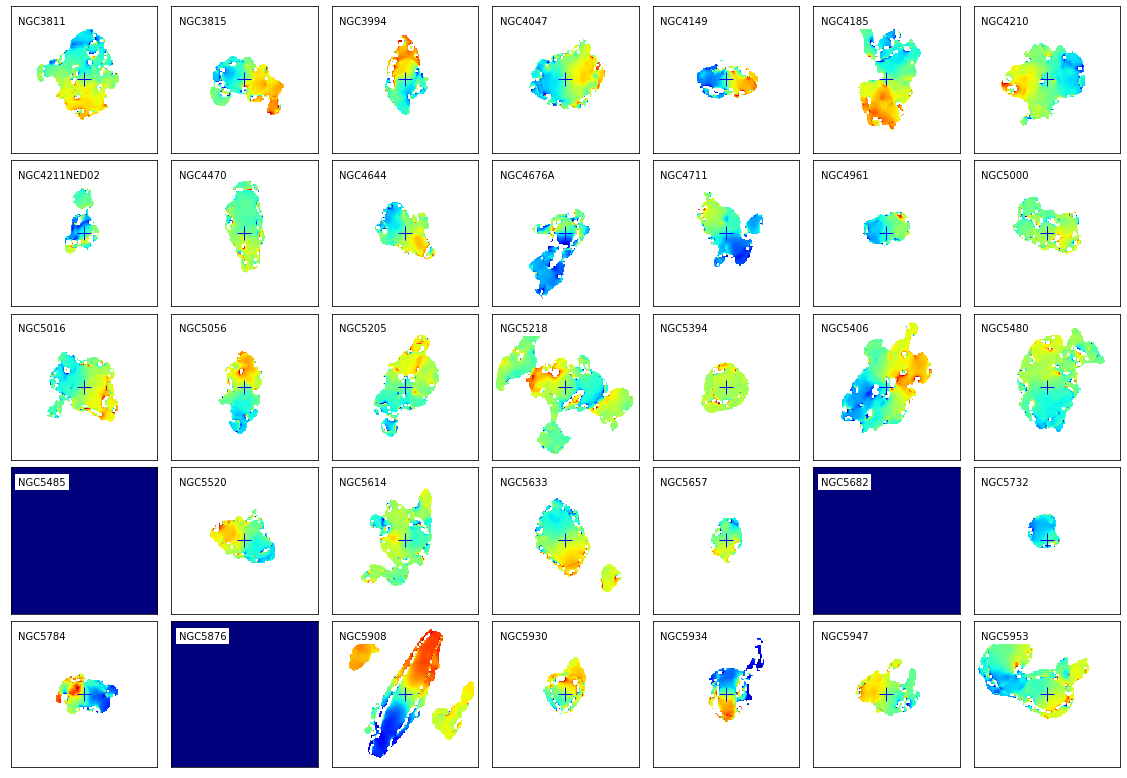

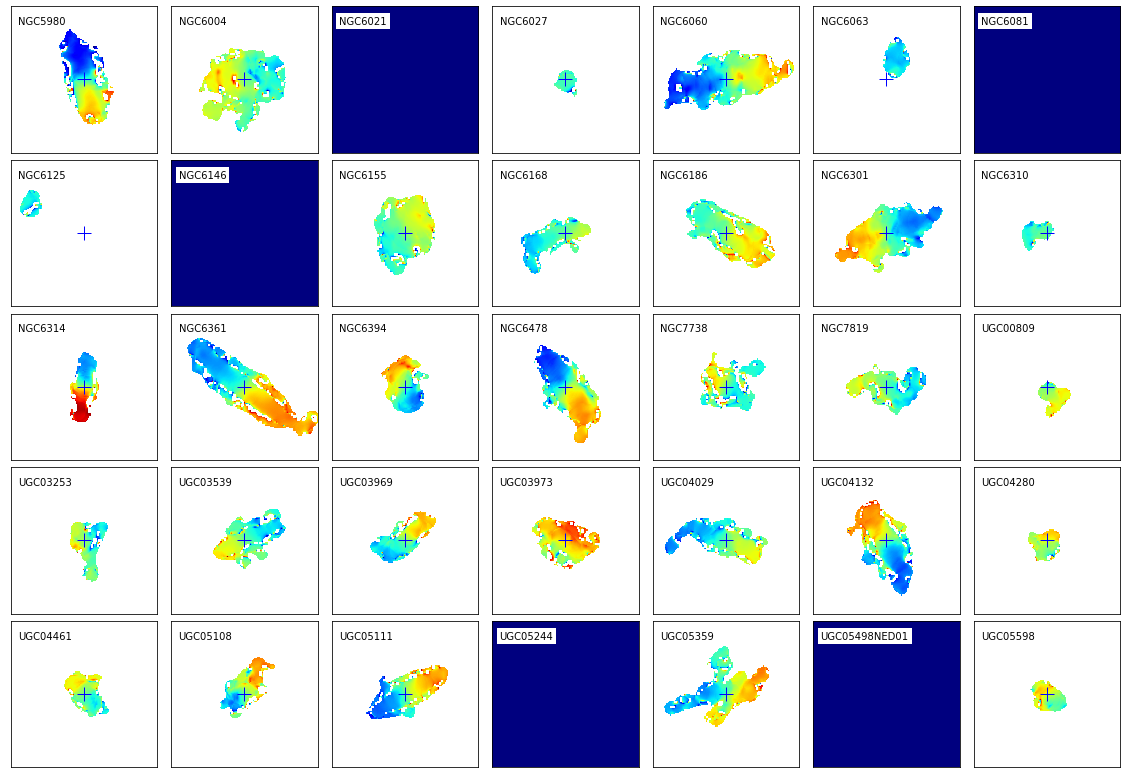

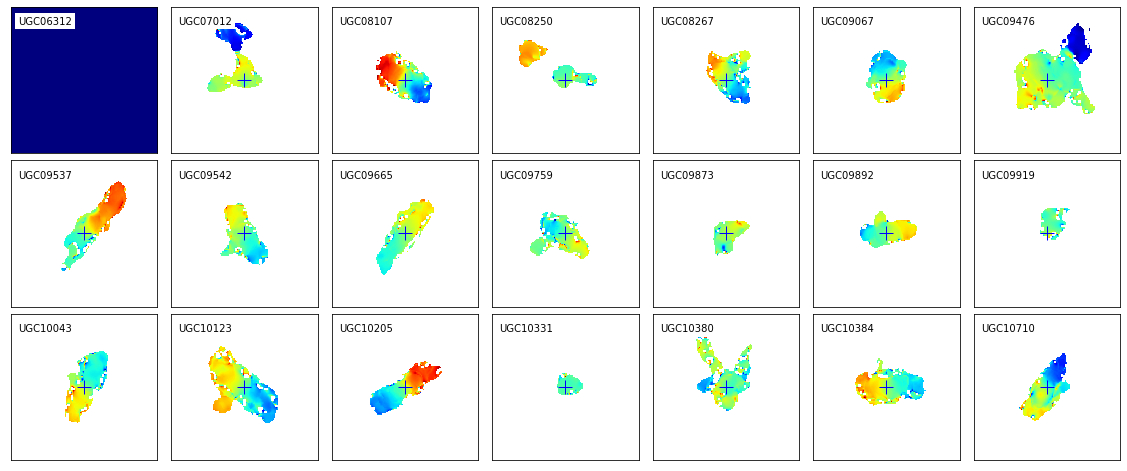

Python Results with error masking


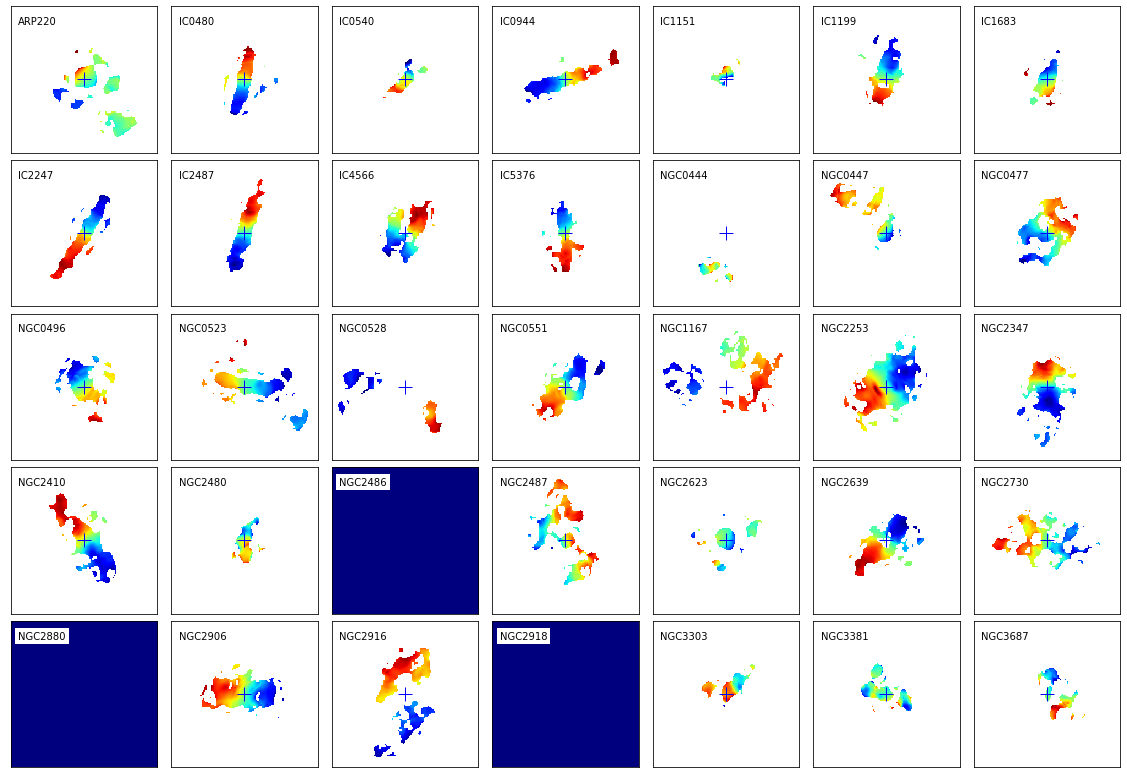

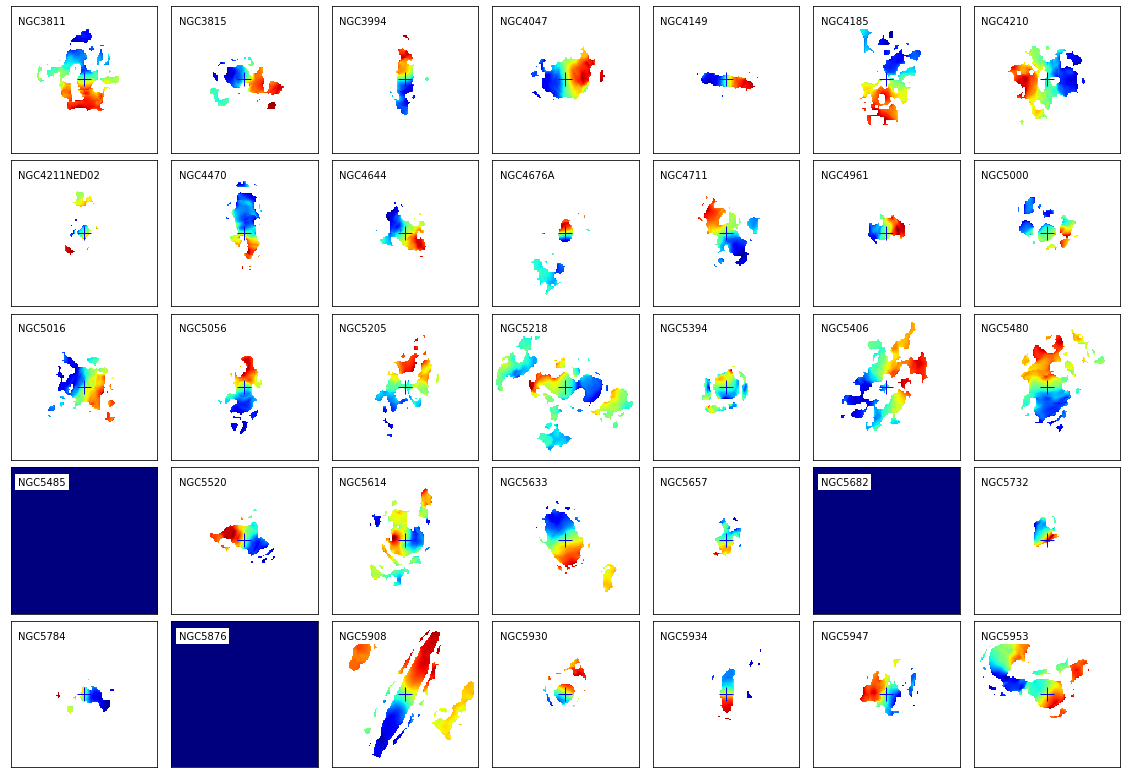

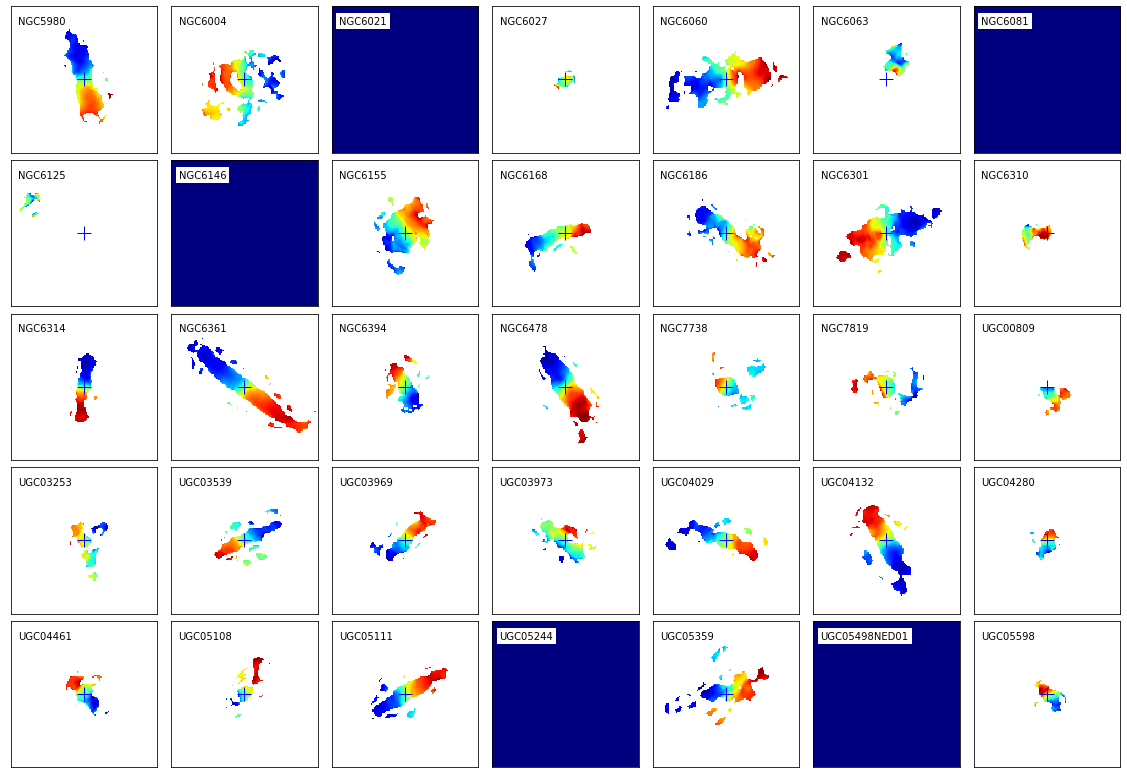

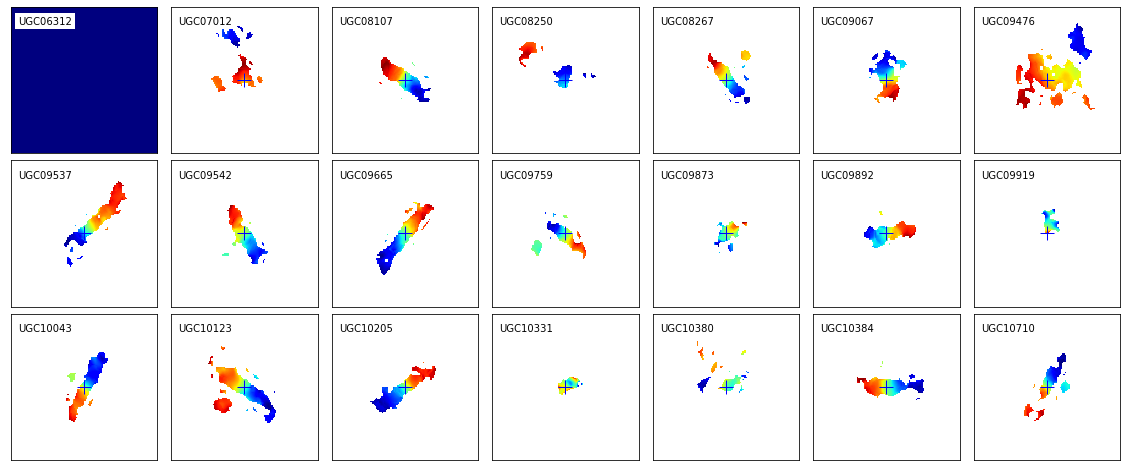

In [9]:
print('IDL Results')
implots(gallist, lbl='idl', imtype='smo7_smo.mom1', imdir='../smo7_idlmom', ctr_tab=leda, pdfout=pdfout)
print('Python Results')
implots(gallist, lbl='py', imtype='smo7_smo.mom1', imdir='../smo7_mom_vrad', ctr_tab=leda, pdfout=pdfout)
print('Python Results with error masking')
implots(gallist, lbl='py', imtype='smo7_smo.mom1', imdir='../smo7_mom_vrad', ctr_tab=leda, 
        errtype='smo7_smo.emom1', errmax=40, pdfout=pdfout)